#Importing necessary libraries

In [153]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.stattools import adfuller


##Reading the datasets and merging them

In [66]:
import pandas as pd
import matplotlib.pylab as plt

# Define the paths to the datasets
productA_path = r'C:\Users\sravy\Downloads\ProductA.xlsx'
fb_impressions_path = r'C:\Users\sravy\Downloads\ProductA_fb_impressions.xlsx'
google_clicks_path = r'C:\Users\sravy\Downloads\ProductA_google_clicks.xlsx'

# Load the datasets into DataFrames
productA = pd.read_excel(productA_path)
fb_impressions = pd.read_excel(fb_impressions_path)
google_clicks = pd.read_excel(google_clicks_path)

# Merge the datasets on 'Day Index'
merged_data = productA.merge(google_clicks, on='Day Index').merge(fb_impressions, on='Day Index')

# Reorder the columns
merged_data = merged_data[['Day Index', 'Quantity', 'Clicks', 'Impressions']]

# Save the merged dataset to an Excel file
merged_data_path = r'C:\Users\sravy\Downloads\master_dataset.xlsx'
merged_data.to_excel(merged_data_path, index=False)

# Display the merged dataset with a heading
print("\n### Merged Data ###")
print(merged_data.head())



### Merged Data ###
   Day Index  Quantity  Clicks  Impressions
0 2021-12-01        14     445          620
1 2021-12-02        10     433          890
2 2021-12-03        13     424          851
3 2021-12-04        22     427          881
4 2021-12-05        33     451          678


#Descriptive Statistics

In [67]:
merged_data.shape

(212, 4)

In [68]:
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 212 entries, 0 to 211
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Day Index    212 non-null    datetime64[ns]
 1   Quantity     212 non-null    int64         
 2   Clicks       212 non-null    int64         
 3   Impressions  212 non-null    int64         
dtypes: datetime64[ns](1), int64(3)
memory usage: 8.3 KB


In [71]:
merged_data.describe()

,Quantity,Clicks,Impressions
count,212.000000,212.00000,212.000000
mean,17.542453,358.20283,1531.702830
std,5.790423,164.52160,440.660783
min,5.000000,60.00000,620.000000
25%,13.750000,154.00000,1209.750000
50%,17.000000,402.50000,1460.000000
75%,21.000000,492.75000,1862.000000
max,38.000000,726.00000,2707.000000


#Missing Value Check

In [72]:
print("Null values:")
merged_data.isnull().sum()

Null values:


Day Index      0
Quantity       0
Clicks         0
Impressions    0
dtype: int64

In [73]:
merged_data.shape

(212, 4)

#Dropping Duplicates

In [74]:
merged_data.drop_duplicates()

,Day Index,Quantity,Clicks,Impressions
0,2021-12-01,14,445,620
1,2021-12-02,10,433,890
2,2021-12-03,13,424,851
3,2021-12-04,22,427,881
4,2021-12-05,33,451,678
...,...,...,...,...
207,2022-06-26,13,114,1218
208,2022-06-27,16,106,1311
209,2022-06-28,13,109,885
210,2022-06-29,16,60,1000


#Analysing the Outliers

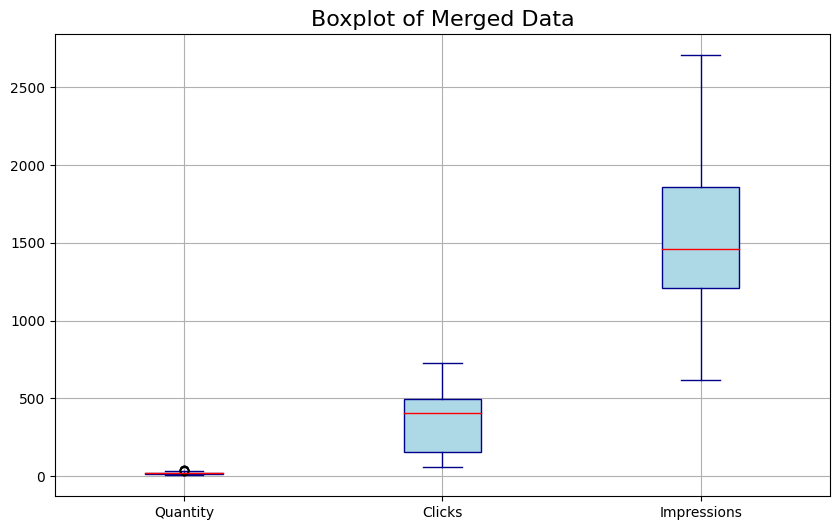

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
merged_data.boxplot(patch_artist=True, 
                    boxprops=dict(facecolor='lightblue', color='darkblue'), 
                    whiskerprops=dict(color='darkblue'),
                    capprops=dict(color='darkblue'),
                    medianprops=dict(color='red'))
plt.title("Boxplot of Merged Data", fontsize=16)
plt.show()


In [79]:
def find_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    return outliers

quantity_outliers = find_outliers_iqr(merged_data, 'Quantity')

print("Quantity Outliers:")
print(quantity_outliers[['Day Index', 'Quantity']])


Quantity Outliers:
     Day Index  Quantity
4   2021-12-05        33
9   2021-12-10        38
78  2022-02-17        38
113 2022-03-24        32
142 2022-04-22        36


#Replacing the outliers with 93rd percentile value

In [82]:
def replace_outliers_with_percentile(df, column, percentile=93):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    percentile_value = df[column].quantile(percentile / 100)
    df[column] = df[column].apply(lambda x: percentile_value if x < lower_bound or x > upper_bound else x)
    return percentile_value

percentile_value = replace_outliers_with_percentile(merged_data, 'Quantity', 93)

print(f"93rd Percentile Value: {percentile_value}")


93rd Percentile Value: 26.0


In [83]:
def add_imputed_column(df, column, percentile=93):
    percentile_value = df[column].quantile(percentile / 100)
    df['Imputed_Quantity'] = df[column].apply(lambda x: percentile_value if x < df[column].quantile(0.25) - 1.5 * (df[column].quantile(0.75) - df[column].quantile(0.25)) or x > df[column].quantile(0.75) + 1.5 * (df[column].quantile(0.75) - df[column].quantile(0.25)) else x)
    return df

merged_data = add_imputed_column(merged_data, 'Quantity', 93)


In [85]:
if quantity_outliers.empty:
    print("Quantity Outliers:\n0")
else:
    print(f"Quantity Outliers:\n{quantity_outliers[['Day Index', 'Quantity']]}")


Quantity Outliers:
0


#FEATURE ENGINEERING

In [86]:
merged_data.head()

,Day Index,Quantity,Clicks,Impressions,Imputed_Quantity
0,2021-12-01,14.0,445,620,14.0
1,2021-12-02,10.0,433,890,10.0
2,2021-12-03,13.0,424,851,13.0
3,2021-12-04,22.0,427,881,22.0
4,2021-12-05,26.0,451,678,26.0


In [87]:
import numpy as np

merged_data['log_quantity'] = np.log1p(merged_data['Quantity'])
merged_data['log_clicks'] = np.log1p(merged_data['Clicks'])
merged_data['log_impressions'] = np.log1p(merged_data['Impressions'])


In [88]:
merged_data['Month'] = merged_data['Day Index'].dt.month
merged_data['Year'] = merged_data['Day Index'].dt.year


In [89]:
merged_data['Month_Name'] = merged_data['Day Index'].dt.month_name()


In [90]:
merged_data['Day_Of_Week'] = merged_data['Day Index'].dt.day_name()


In [91]:
merged_data['Week_Of_Month'] = (merged_data['Day Index'].dt.day - 1) // 7 + 1


In [92]:
merged_data['Day_Of_Week_Numeric'] = merged_data['Day Index'].dt.weekday


In [93]:
merged_data['Month_Numeric'] = merged_data['Day Index'].dt.month


In [96]:
weekdays = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
for day in weekdays:
    merged_data[day] = merged_data['Day_Of_Week'].apply(lambda x: 1 if x == day else 0)


In [97]:
months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
for month in months:
    merged_data[month] = merged_data['Month_Name'].apply(lambda x: 1 if x == month else 0)


In [98]:
merged_data.fillna(0, inplace=True)


In [100]:
merged_data.columns

Index(['Day Index', 'Quantity', 'Clicks', 'Impressions', 'Imputed_Quantity',
       'log_quantity', 'log_clicks', 'log_impressions', 'Month', 'Year',
       'Month_Name', 'Day_Of_Week', 'Week_Of_Month', 'Day_Of_Week_Numeric',
       'Month_Numeric', 'Weekday_1', 'Month_1', 'Monday', 'Tuesday',
       'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday', 'January',
       'February', 'March', 'April', 'May', 'June', 'July', 'August',
       'September', 'October', 'November', 'December'],
      dtype='object')

In [102]:
merged_data.head()

,Day Index,Quantity,Clicks,Impressions,Imputed_Quantity,log_quantity,log_clicks,log_impressions,Month,Year,Month_Name,Day_Of_Week,Week_Of_Month,Day_Of_Week_Numeric,Month_Numeric,Weekday_1,Month_1,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday,January,February,March,April,May,June,July,August,September,October,November,December
0,2021-12-01,14.0,445,620,14.0,2.708050,6.100319,6.431331,12,2021,December,Wednesday,1,2,12,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,2021-12-02,10.0,433,890,10.0,2.397895,6.073045,6.792344,12,2021,December,Thursday,1,3,12,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,2021-12-03,13.0,424,851,13.0,2.639057,6.052089,6.747587,12,2021,December,Friday,1,4,12,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,2021-12-04,22.0,427,881,22.0,3.135494,6.059123,6.782192,12,2021,December,Saturday,1,5,12,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1
4,2021-12-05,26.0,451,678,26.0,3.295837,6.113682,6.520621,12,2021,December,Sunday,1,6,12,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1


In [103]:
merged_data.to_csv('final_dataset.csv', index=False)


#Data Analysis

##Correlation Heatmap

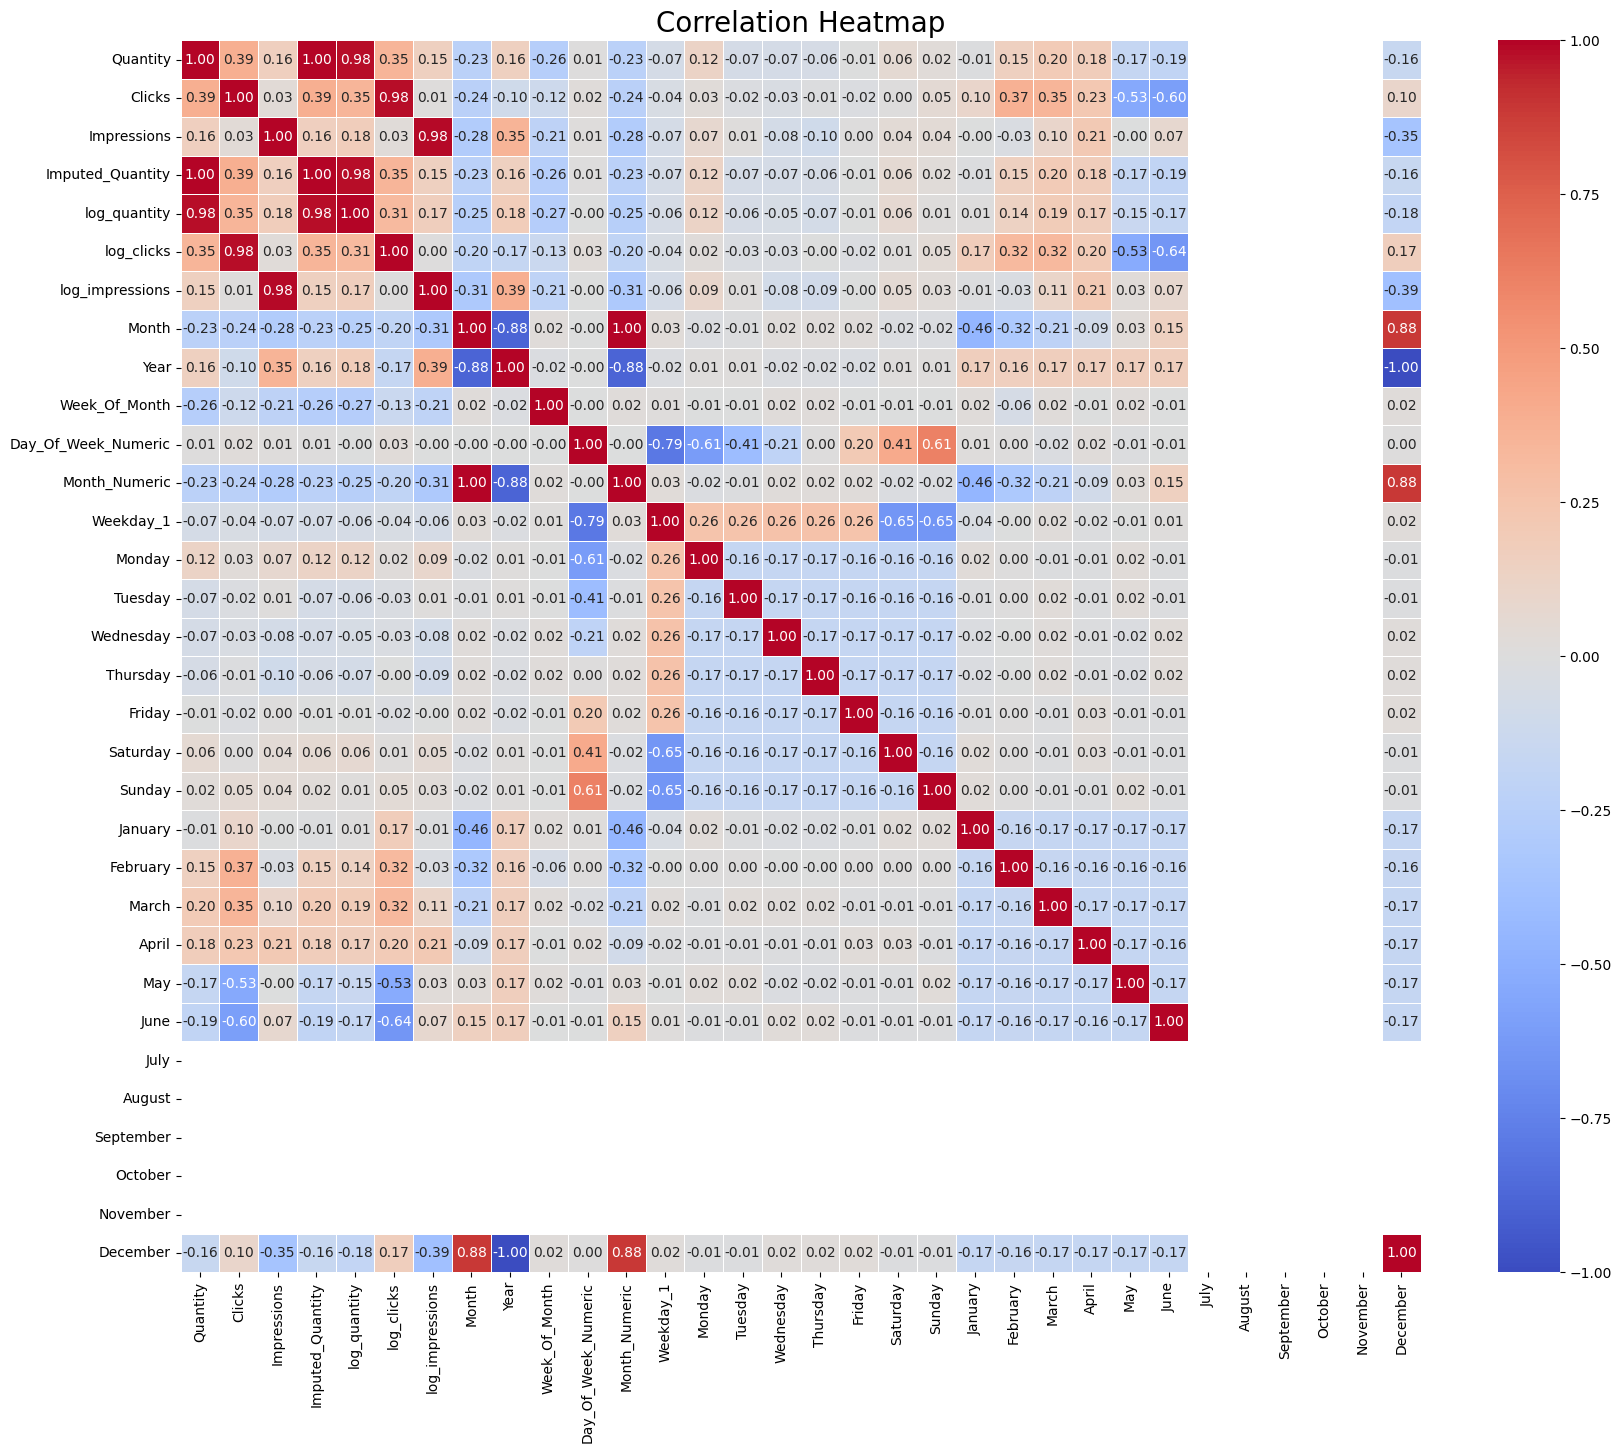

In [109]:
# Drop the 'month_1' column
merged_data = merged_data.drop(columns=['Month_1'], axis=1)

# Plot the correlation heatmap
plt.figure(figsize=(20, 16))
sns.heatmap(merged_data.corr(), annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap', fontsize=20)
plt.show()


There is a strong positive correlation between Quantity and Clicks.
Impressions have a moderate positive correlation with Quantity.
Impressions and Clicks have a very weak positive correlation.

##Quantity vs Clicks

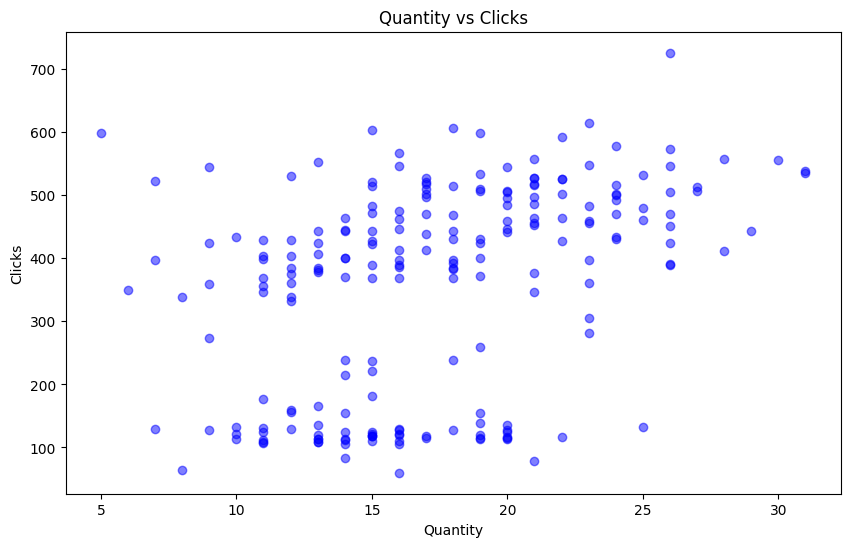

In [110]:
plt.figure(figsize=(10, 6))
plt.scatter(merged_data['Quantity'], merged_data['Clicks'], c='blue', alpha=0.5)
plt.title('Quantity vs Clicks')
plt.xlabel('Quantity')
plt.ylabel('Clicks')
plt.show()


##Quantity vs Impressions

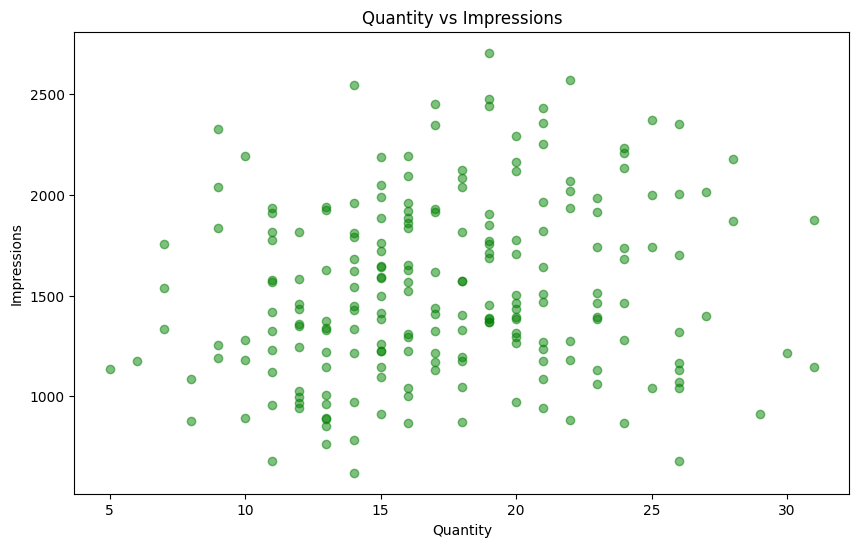

In [111]:
plt.figure(figsize=(10, 6))
plt.scatter(merged_data['Quantity'], merged_data['Impressions'], c='green', alpha=0.5)
plt.title('Quantity vs Impressions')
plt.xlabel('Quantity')
plt.ylabel('Impressions')
plt.show()


##Clicks vs Impressions

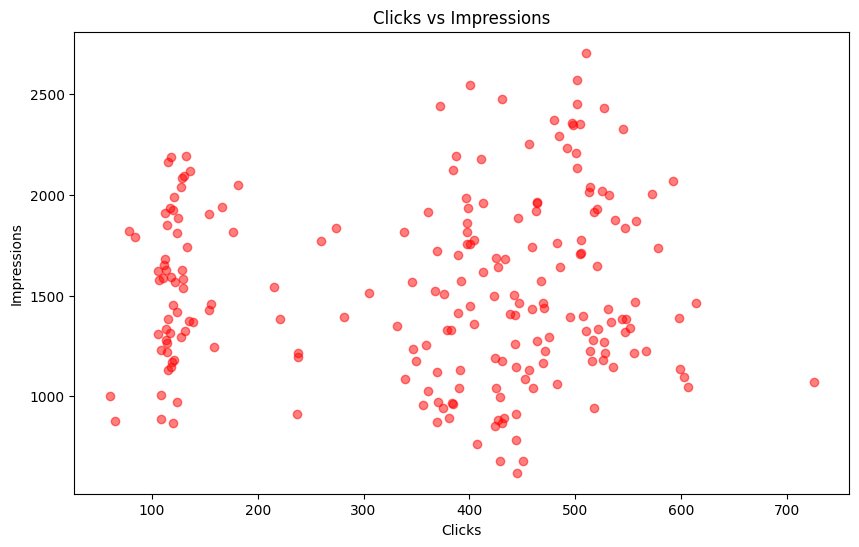

In [112]:
plt.figure(figsize=(10, 6))
plt.scatter(merged_data['Clicks'], merged_data['Impressions'], c='red', alpha=0.5)
plt.title('Clicks vs Impressions')
plt.xlabel('Clicks')
plt.ylabel('Impressions')
plt.show()


##Day-wise Qunatity analysis

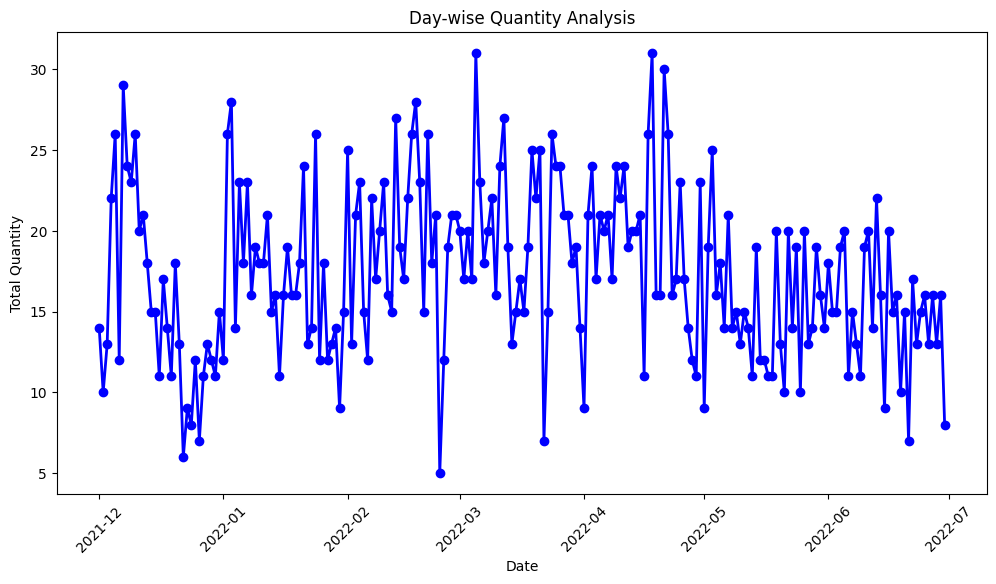

In [119]:
# Group by Day Index and sum the Quantity for each day
merged_data['Day Index'] = pd.to_datetime(merged_data['Day Index'])
daily_quantity = merged_data.groupby(merged_data['Day Index'].dt.date)['Quantity'].sum()

plt.figure(figsize=(12, 6))
plt.plot(daily_quantity.index, daily_quantity.values, marker='o', color='blue', linestyle='-', linewidth=2)
plt.title('Day-wise Quantity Analysis')
plt.xlabel('Date')
plt.ylabel('Total Quantity')
plt.xticks(rotation=45)
plt.show()


##Sales are peaked in December,March and April and least impressions in End of december and January

##Day-wise Clicks Analysis

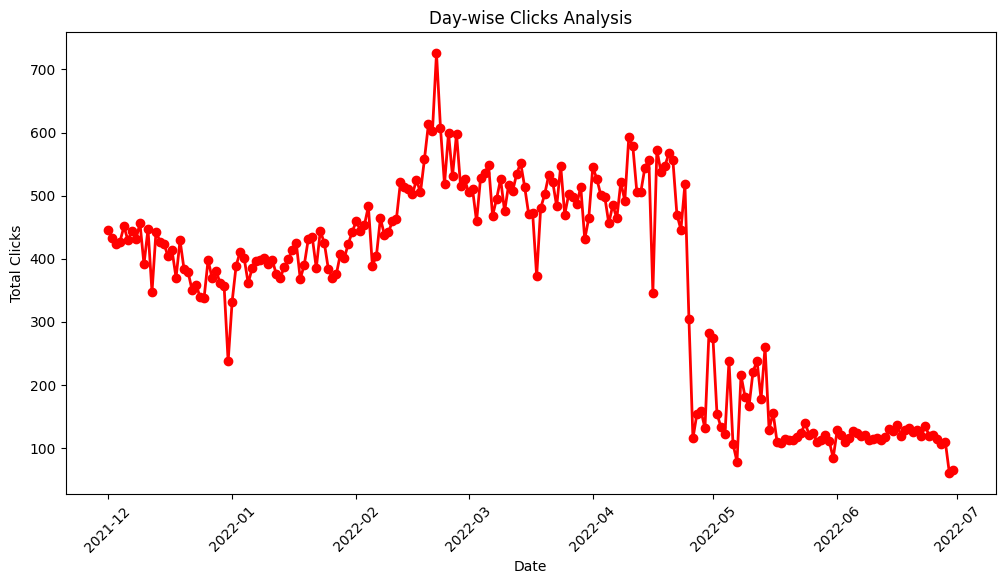

In [114]:
daily_clicks = merged_data.groupby(merged_data['Day Index'].dt.date)['Clicks'].sum()

plt.figure(figsize=(12, 6))
plt.plot(daily_clicks.index, daily_clicks.values, marker='o', color='red', linestyle='-', linewidth=2)
plt.title('Day-wise Clicks Analysis')
plt.xlabel('Date')
plt.ylabel('Total Clicks')
plt.xticks(rotation=45)
plt.show()


##Day-wise Impressions Analysis

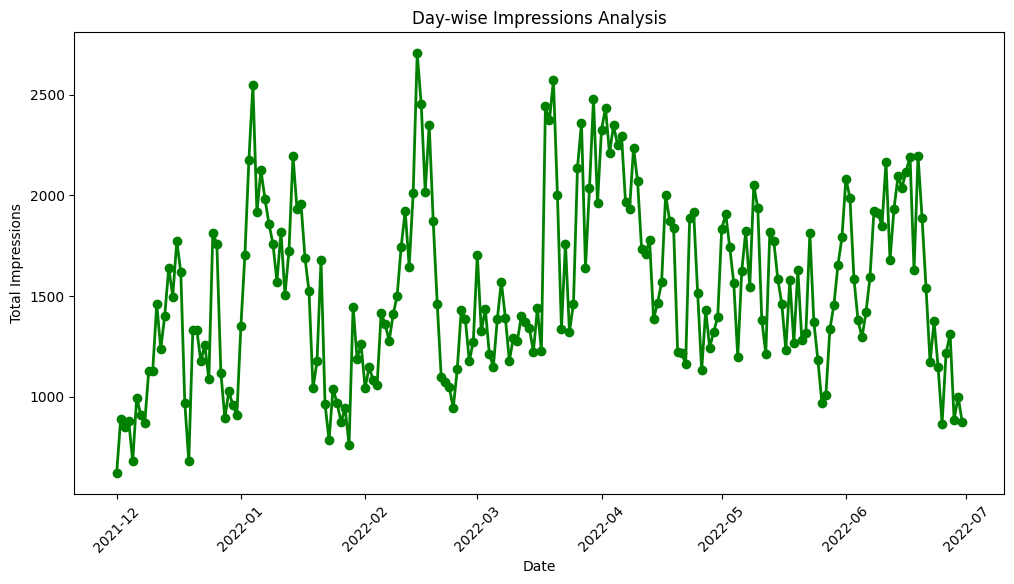

In [115]:
daily_impressions = merged_data.groupby(merged_data['Day Index'].dt.date)['Impressions'].sum()

plt.figure(figsize=(12, 6))
plt.plot(daily_impressions.index, daily_impressions.values, marker='o', color='green', linestyle='-', linewidth=2)
plt.title('Day-wise Impressions Analysis')
plt.xlabel('Date')
plt.ylabel('Total Impressions')
plt.xticks(rotation=45)
plt.show()


###Impressions peaked in february month 
###Least impressions are in December

##Day-wise Total Analysis (Quantity, Clicks, and Impressions)

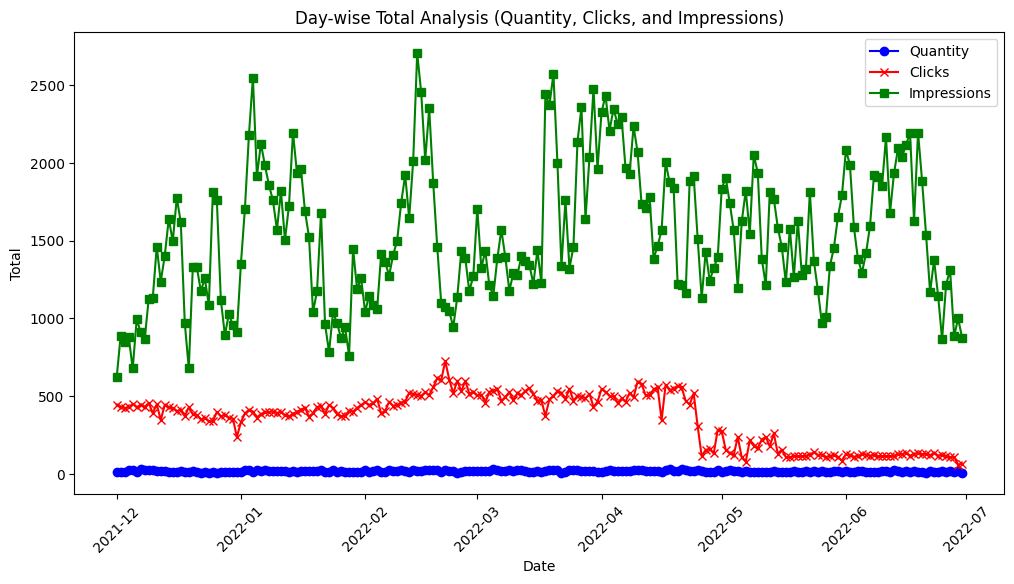

In [116]:
daily_total = merged_data.groupby(merged_data['Day Index'].dt.date)[['Quantity', 'Clicks', 'Impressions']].sum()

plt.figure(figsize=(12, 6))
plt.plot(daily_total.index, daily_total['Quantity'], label='Quantity', color='blue', marker='o')
plt.plot(daily_total.index, daily_total['Clicks'], label='Clicks', color='red', marker='x')
plt.plot(daily_total.index, daily_total['Impressions'], label='Impressions', color='green', marker='s')
plt.title('Day-wise Total Analysis (Quantity, Clicks, and Impressions)')
plt.xlabel('Date')
plt.ylabel('Total')
plt.xticks(rotation=45)
plt.legend()
plt.show()


#WEEKDAYS ANALYSIS

##Weekday-wise Quantity Analysis

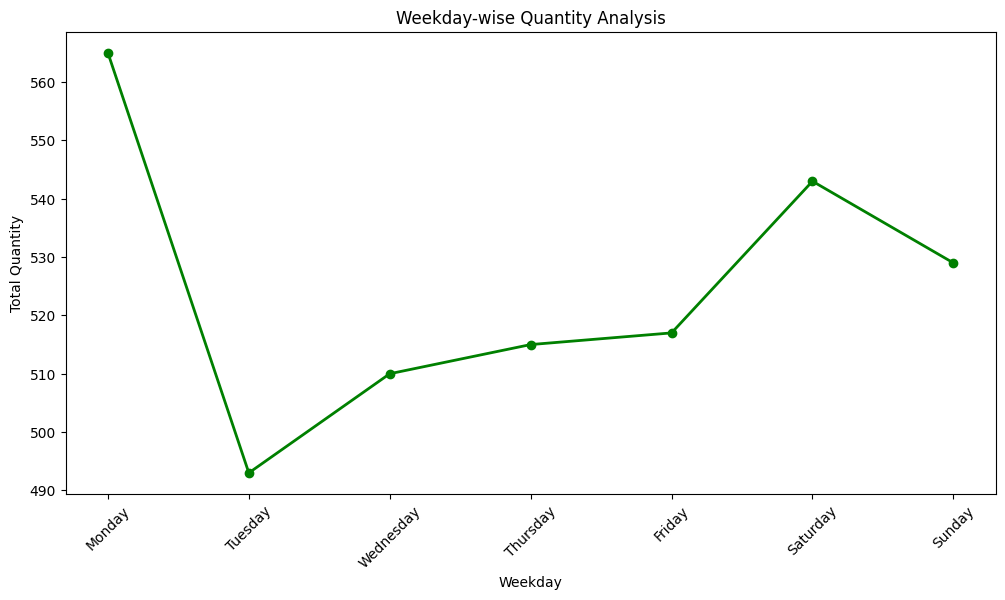

In [122]:
# Group by Day Index and sum the Quantity for each weekday
weekday_quantity = merged_data.groupby(merged_data['Day Index'].dt.dayofweek)['Quantity'].sum()

# Map the day numbers to weekday names
weekday_quantity.index = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

plt.figure(figsize=(12, 6))
plt.plot(weekday_quantity.index, weekday_quantity.values, marker='o', color='green', linestyle='-', linewidth=2)
plt.title('Weekday-wise Quantity Analysis')
plt.xlabel('Weekday')
plt.ylabel('Total Quantity')
plt.xticks(rotation=45)
plt.show()


###Sales peak on Saturday, indicating higher shopping activity during the weekend and Sales are lowest on Thursday, suggesting lower consumer engagement during the mid-week.

##WEEKDAY AND WEEKEND SALES COMPARISION

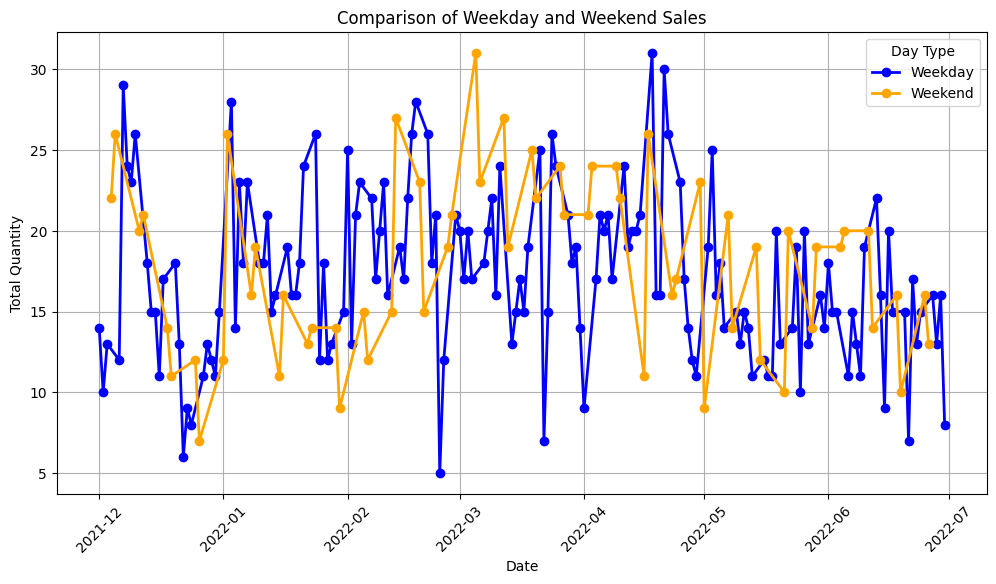

Weekday Sales: 2600.0
Weekend Sales: 1072.0


In [128]:
# Add a new column 'Weekday' to categorize the days
merged_data['Weekday'] = merged_data['Day Index'].dt.dayofweek

# Create a new column to categorize into 'Weekday' and 'Weekend'
merged_data['Day Type'] = merged_data['Weekday'].apply(lambda x: 'Weekend' if x >= 5 else 'Weekday')

# Group by 'Day Type' and Day Index, then sum the Quantity
day_type_quantity = merged_data.groupby(['Day Type', 'Day Index'])['Quantity'].sum().reset_index()

# Separate data for weekdays and weekends
weekday_data = day_type_quantity[day_type_quantity['Day Type'] == 'Weekday']
weekend_data = day_type_quantity[day_type_quantity['Day Type'] == 'Weekend']

# Plot the comparison using a line plot
plt.figure(figsize=(12, 6))

# Plot weekday data
plt.plot(weekday_data['Day Index'], weekday_data['Quantity'], label='Weekday', marker='o', linestyle='-', linewidth=2, color='blue')

# Plot weekend data
plt.plot(weekend_data['Day Index'], weekend_data['Quantity'], label='Weekend', marker='o', linestyle='-', linewidth=2, color='orange')

plt.title('Comparison of Weekday and Weekend Sales')
plt.xlabel('Date')
plt.ylabel('Total Quantity')
plt.legend(title='Day Type')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

# Points for this:
weekday_sales = day_type_quantity[day_type_quantity['Day Type'] == 'Weekday']['Quantity'].sum()
weekend_sales = day_type_quantity[day_type_quantity['Day Type'] == 'Weekend']['Quantity'].sum()
print(f"Weekday Sales: {weekday_sales}")
print(f"Weekend Sales: {weekend_sales}")



###Weekend sales show more variability, with some peaks indicating high sales on certain weekends.

##Comparison of Weekday and Weekend Clicks

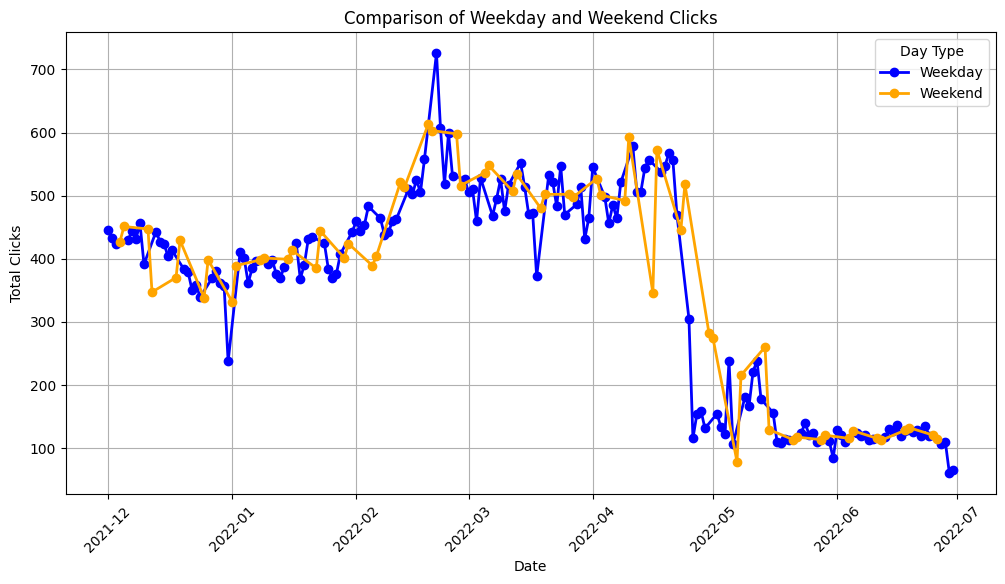

Weekday Clicks: 53822
Weekend Clicks: 22117


In [129]:
# Group by 'Day Type' and Day Index, then sum the Clicks
day_type_clicks = merged_data.groupby(['Day Type', 'Day Index'])['Clicks'].sum().reset_index()

# Separate data for weekdays and weekends
weekday_clicks = day_type_clicks[day_type_clicks['Day Type'] == 'Weekday']
weekend_clicks = day_type_clicks[day_type_clicks['Day Type'] == 'Weekend']

# Plot the comparison using a line plot
plt.figure(figsize=(12, 6))

# Plot weekday data
plt.plot(weekday_clicks['Day Index'], weekday_clicks['Clicks'], label='Weekday', marker='o', linestyle='-', linewidth=2, color='blue')

# Plot weekend data
plt.plot(weekend_clicks['Day Index'], weekend_clicks['Clicks'], label='Weekend', marker='o', linestyle='-', linewidth=2, color='orange')

plt.title('Comparison of Weekday and Weekend Clicks')
plt.xlabel('Date')
plt.ylabel('Total Clicks')
plt.legend(title='Day Type')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

# Points for this:
weekday_clicks_total = day_type_clicks[day_type_clicks['Day Type'] == 'Weekday']['Clicks'].sum()
weekend_clicks_total = day_type_clicks[day_type_clicks['Day Type'] == 'Weekend']['Clicks'].sum()
print(f"Weekday Clicks: {weekday_clicks_total}")
print(f"Weekend Clicks: {weekend_clicks_total}")


###Weekday clicks are higher overall compared to weekend clicks.

##Comparison of Weekday and Weekend Impressions

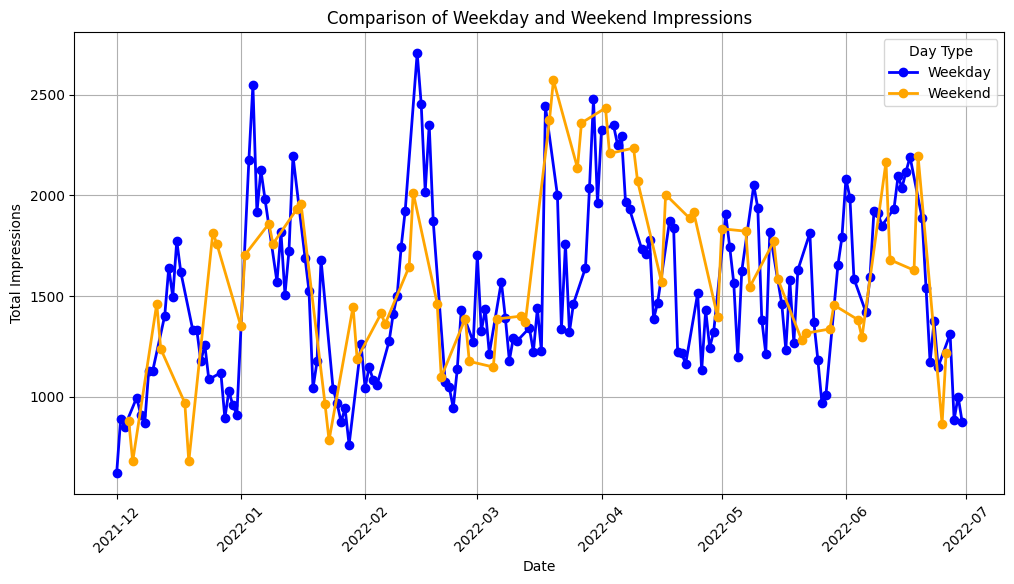

Weekday Impressions: 229914
Weekend Impressions: 94807


In [130]:
# Group by 'Day Type' and Day Index, then sum the Impressions
day_type_impressions = merged_data.groupby(['Day Type', 'Day Index'])['Impressions'].sum().reset_index()

# Separate data for weekdays and weekends
weekday_impressions = day_type_impressions[day_type_impressions['Day Type'] == 'Weekday']
weekend_impressions = day_type_impressions[day_type_impressions['Day Type'] == 'Weekend']

# Plot the comparison using a line plot
plt.figure(figsize=(12, 6))

# Plot weekday data
plt.plot(weekday_impressions['Day Index'], weekday_impressions['Impressions'], label='Weekday', marker='o', linestyle='-', linewidth=2, color='blue')

# Plot weekend data
plt.plot(weekend_impressions['Day Index'], weekend_impressions['Impressions'], label='Weekend', marker='o', linestyle='-', linewidth=2, color='orange')

plt.title('Comparison of Weekday and Weekend Impressions')
plt.xlabel('Date')
plt.ylabel('Total Impressions')
plt.legend(title='Day Type')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

# Points for this:
weekday_impressions_total = day_type_impressions[day_type_impressions['Day Type'] == 'Weekday']['Impressions'].sum()
weekend_impressions_total = day_type_impressions[day_type_impressions['Day Type'] == 'Weekend']['Impressions'].sum()
print(f"Weekday Impressions: {weekday_impressions_total}")
print(f"Weekend Impressions: {weekend_impressions_total}")


###Weekday impressions are higher, suggesting more visibility during weekdays.

##MONTH WISE ANALYSIS

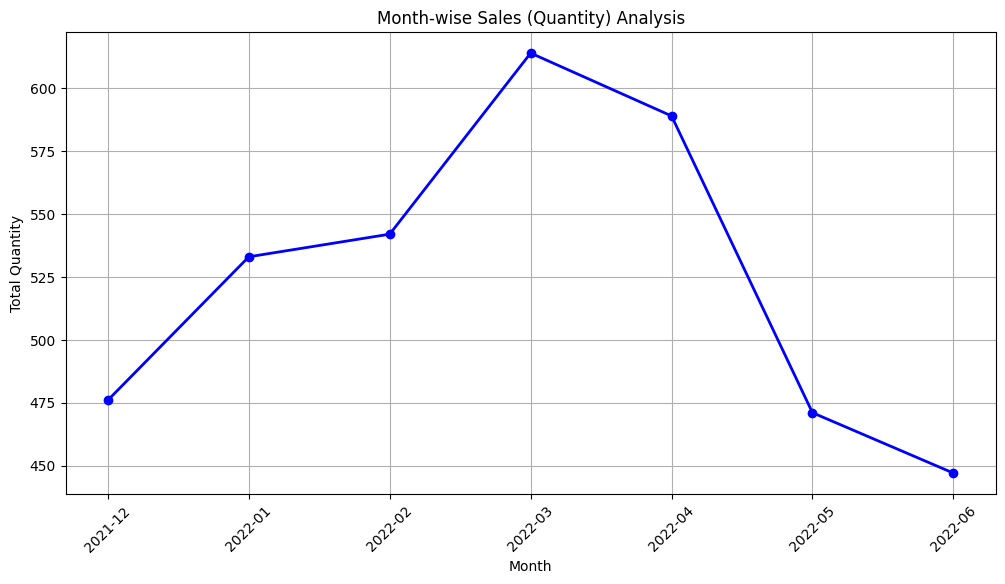

Sales peaked in 2022-03.
Sales were lowest in 2022-06.


In [131]:
# Extract the month and year from the 'Day Index'
merged_data['Month'] = merged_data['Day Index'].dt.to_period('M')

# Group by Month and sum the Quantity
month_quantity = merged_data.groupby('Month')['Quantity'].sum().reset_index()

# Plot the month-wise sales
plt.figure(figsize=(12, 6))
plt.plot(month_quantity['Month'].astype(str), month_quantity['Quantity'], marker='o', color='blue', linestyle='-', linewidth=2)
plt.title('Month-wise Sales (Quantity) Analysis')
plt.xlabel('Month')
plt.ylabel('Total Quantity')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

# Points for this:
max_quantity_month = month_quantity.loc[month_quantity['Quantity'].idxmax()]['Month']
min_quantity_month = month_quantity.loc[month_quantity['Quantity'].idxmin()]['Month']
print(f"Sales peaked in {max_quantity_month}.")
print(f"Sales were lowest in {min_quantity_month}.")


##Month-wise Analysis of Clicks

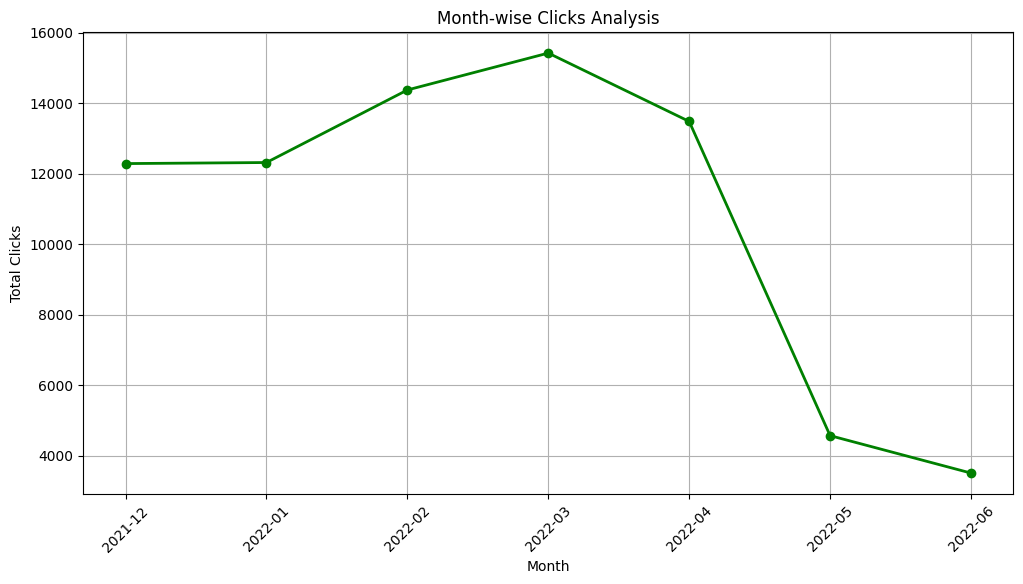

Clicks peaked in 2022-03.
Clicks were lowest in 2022-06.


In [132]:
# Group by Month and sum the Clicks
month_clicks = merged_data.groupby('Month')['Clicks'].sum().reset_index()

# Plot the month-wise clicks
plt.figure(figsize=(12, 6))
plt.plot(month_clicks['Month'].astype(str), month_clicks['Clicks'], marker='o', color='green', linestyle='-', linewidth=2)
plt.title('Month-wise Clicks Analysis')
plt.xlabel('Month')
plt.ylabel('Total Clicks')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

# Points for this:
max_clicks_month = month_clicks.loc[month_clicks['Clicks'].idxmax()]['Month']
min_clicks_month = month_clicks.loc[month_clicks['Clicks'].idxmin()]['Month']
print(f"Clicks peaked in {max_clicks_month}.")
print(f"Clicks were lowest in {min_clicks_month}.")


##Month-wise Analysis of Impressions

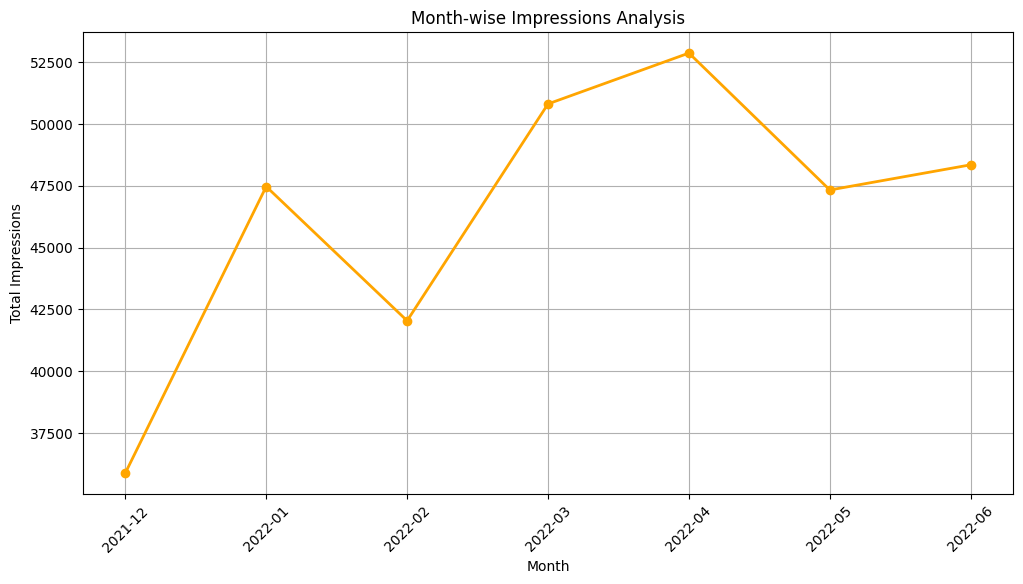

Impressions peaked in 2022-04.
Impressions were lowest in 2021-12.


In [133]:
# Group by Month and sum the Impressions
month_impressions = merged_data.groupby('Month')['Impressions'].sum().reset_index()

# Plot the month-wise impressions
plt.figure(figsize=(12, 6))
plt.plot(month_impressions['Month'].astype(str), month_impressions['Impressions'], marker='o', color='orange', linestyle='-', linewidth=2)
plt.title('Month-wise Impressions Analysis')
plt.xlabel('Month')
plt.ylabel('Total Impressions')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

# Points for this:
max_impressions_month = month_impressions.loc[month_impressions['Impressions'].idxmax()]['Month']
min_impressions_month = month_impressions.loc[month_impressions['Impressions'].idxmin()]['Month']
print(f"Impressions peaked in {max_impressions_month}.")
print(f"Impressions were lowest in {min_impressions_month}.")


##Quarter wise analysis

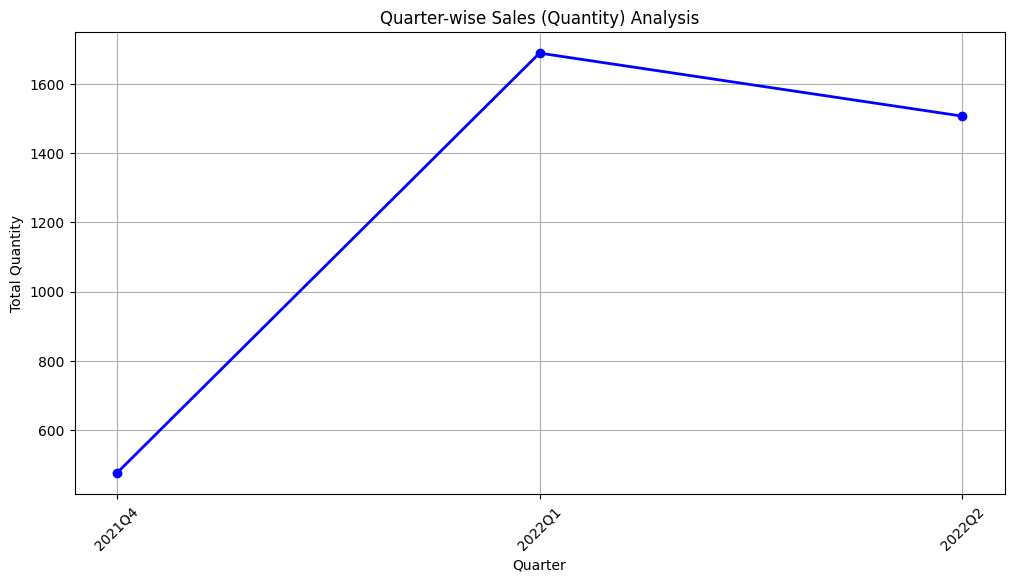

Sales peaked in 2022Q1.
Sales were lowest in 2021Q4.


In [135]:
# Extract the quarter from the 'Day Index'
merged_data['Quarter'] = merged_data['Day Index'].dt.to_period('Q')

# Group by Quarter and sum the Quantity
quarter_quantity = merged_data.groupby('Quarter')['Quantity'].sum().reset_index()

# Plot the quarter-wise sales
plt.figure(figsize=(12, 6))
plt.plot(quarter_quantity['Quarter'].astype(str), quarter_quantity['Quantity'], marker='o', color='blue', linestyle='-', linewidth=2)
plt.title('Quarter-wise Sales (Quantity) Analysis')
plt.xlabel('Quarter')
plt.ylabel('Total Quantity')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

# Points for this:
max_quantity_quarter = quarter_quantity.loc[quarter_quantity['Quantity'].idxmax()]['Quarter']
min_quantity_quarter = quarter_quantity.loc[quarter_quantity['Quantity'].idxmin()]['Quarter']
print(f"Sales peaked in {max_quantity_quarter}.")
print(f"Sales were lowest in {min_quantity_quarter}.")


##Quarter-wise Clicks Analysis

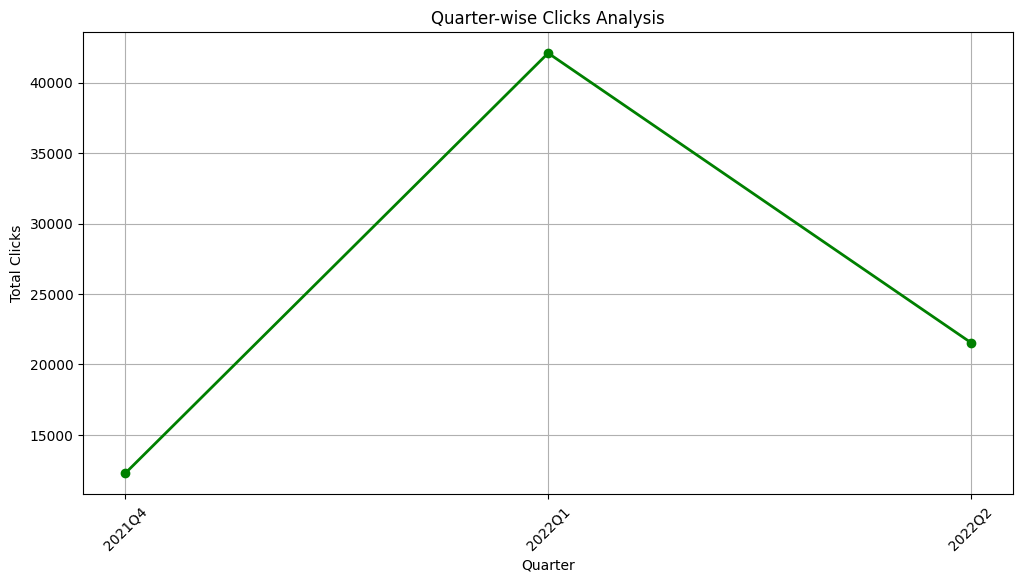

Clicks peaked in 2022Q1.
Clicks were lowest in 2021Q4.


In [136]:
# Group by Quarter and sum the Clicks
quarter_clicks = merged_data.groupby('Quarter')['Clicks'].sum().reset_index()

# Plot the quarter-wise clicks
plt.figure(figsize=(12, 6))
plt.plot(quarter_clicks['Quarter'].astype(str), quarter_clicks['Clicks'], marker='o', color='green', linestyle='-', linewidth=2)
plt.title('Quarter-wise Clicks Analysis')
plt.xlabel('Quarter')
plt.ylabel('Total Clicks')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

# Points for this:
max_clicks_quarter = quarter_clicks.loc[quarter_clicks['Clicks'].idxmax()]['Quarter']
min_clicks_quarter = quarter_clicks.loc[quarter_clicks['Clicks'].idxmin()]['Quarter']
print(f"Clicks peaked in {max_clicks_quarter}.")
print(f"Clicks were lowest in {min_clicks_quarter}.")


##Quarter-wise Impressions Analysis

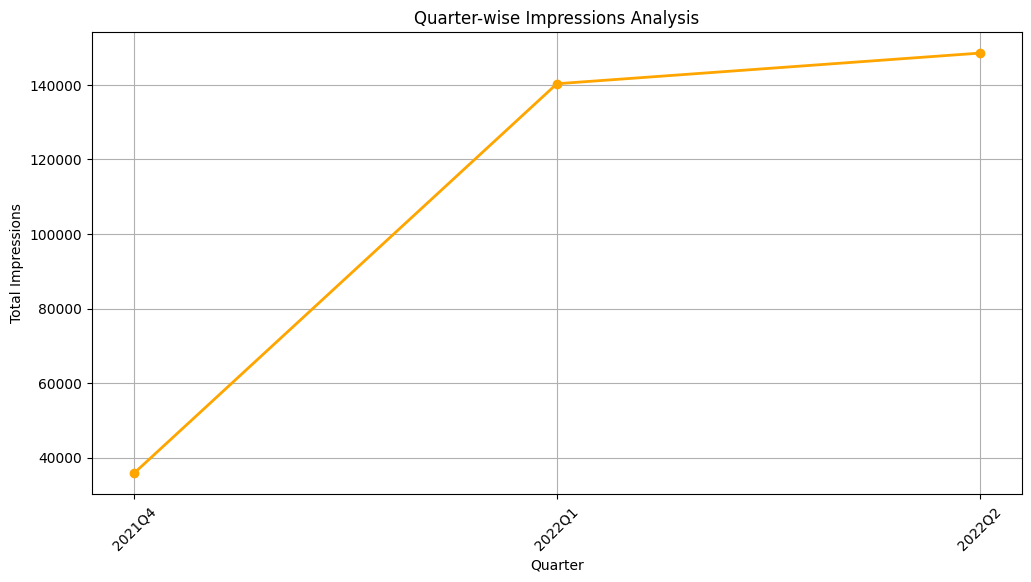

Impressions peaked in 2022Q2.
Impressions were lowest in 2021Q4.


In [137]:
# Group by Quarter and sum the Impressions
quarter_impressions = merged_data.groupby('Quarter')['Impressions'].sum().reset_index()

# Plot the quarter-wise impressions
plt.figure(figsize=(12, 6))
plt.plot(quarter_impressions['Quarter'].astype(str), quarter_impressions['Impressions'], marker='o', color='orange', linestyle='-', linewidth=2)
plt.title('Quarter-wise Impressions Analysis')
plt.xlabel('Quarter')
plt.ylabel('Total Impressions')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

# Points for this:
max_impressions_quarter = quarter_impressions.loc[quarter_impressions['Impressions'].idxmax()]['Quarter']
min_impressions_quarter = quarter_impressions.loc[quarter_impressions['Impressions'].idxmin()]['Quarter']
print(f"Impressions peaked in {max_impressions_quarter}.")
print(f"Impressions were lowest in {min_impressions_quarter}.")


##Monthly Sales (Quantity) Analysis

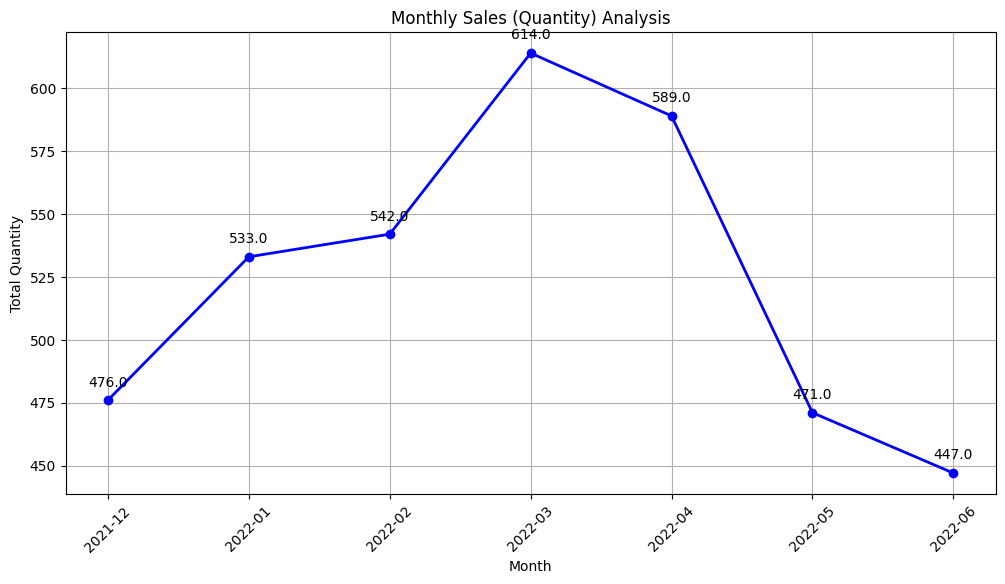

In [139]:
# Group by Month and sum the Quantity
monthly_quantity = merged_data.groupby('Month')['Quantity'].sum().reset_index()

# Plot the monthly sales
plt.figure(figsize=(12, 6))
plt.plot(monthly_quantity['Month'].astype(str), monthly_quantity['Quantity'], marker='o', color='blue', linestyle='-', linewidth=2)
plt.title('Monthly Sales (Quantity) Analysis')
plt.xlabel('Month')
plt.ylabel('Total Quantity')
plt.xticks(rotation=45)
plt.grid(True)

# Add annotations for all data points
for i in range(len(monthly_quantity)):
    plt.annotate(str(monthly_quantity['Quantity'][i]), 
                 xy=(monthly_quantity['Month'][i].strftime('%Y-%m'), monthly_quantity['Quantity'][i]), 
                 textcoords="offset points", xytext=(0,10), ha='center')

plt.show()



##Monthly Clicks Analysis

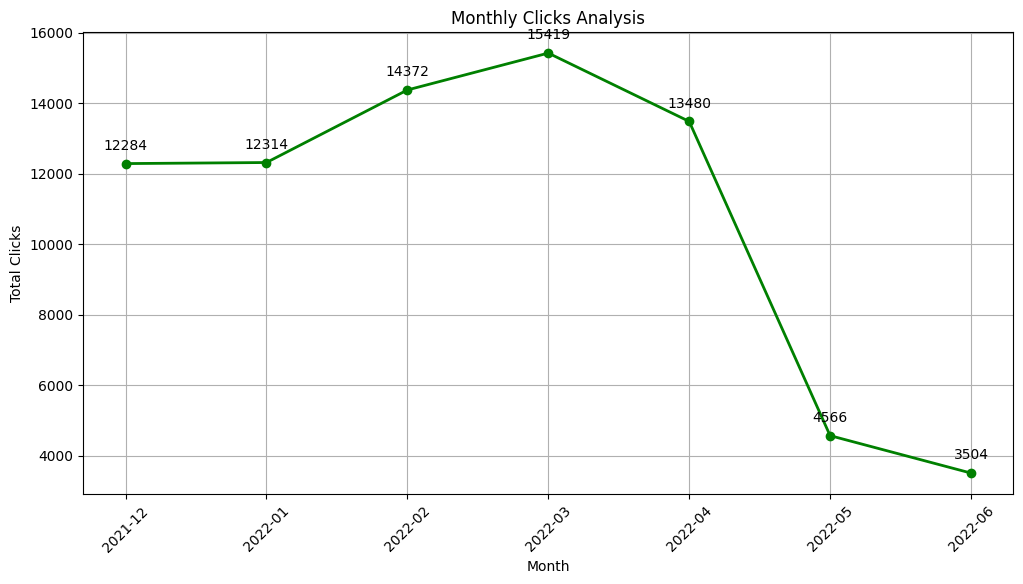

In [140]:
# Group by Month and sum the Clicks
monthly_clicks = merged_data.groupby('Month')['Clicks'].sum().reset_index()

# Plot the monthly clicks
plt.figure(figsize=(12, 6))
plt.plot(monthly_clicks['Month'].astype(str), monthly_clicks['Clicks'], marker='o', color='green', linestyle='-', linewidth=2)
plt.title('Monthly Clicks Analysis')
plt.xlabel('Month')
plt.ylabel('Total Clicks')
plt.xticks(rotation=45)
plt.grid(True)

# Add annotations for all data points
for i in range(len(monthly_clicks)):
    plt.annotate(str(monthly_clicks['Clicks'][i]), 
                 xy=(monthly_clicks['Month'][i].strftime('%Y-%m'), monthly_clicks['Clicks'][i]), 
                 textcoords="offset points", xytext=(0,10), ha='center')

plt.show()


##Monthly Clicks Analysis

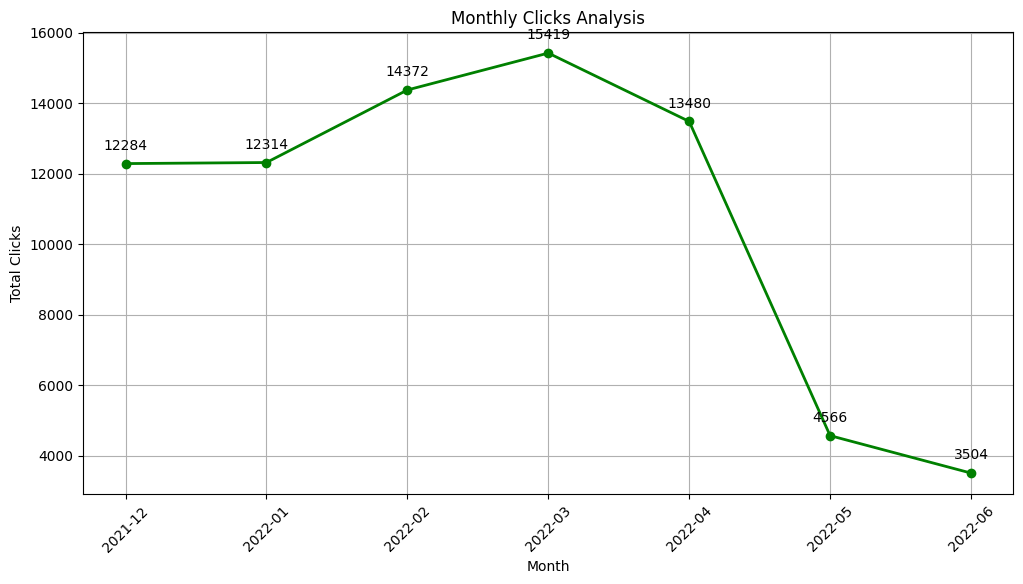

In [141]:
# Group by Month and sum the Clicks
monthly_clicks = merged_data.groupby('Month')['Clicks'].sum().reset_index()

# Plot the monthly clicks
plt.figure(figsize=(12, 6))
plt.plot(monthly_clicks['Month'].astype(str), monthly_clicks['Clicks'], marker='o', color='green', linestyle='-', linewidth=2)
plt.title('Monthly Clicks Analysis')
plt.xlabel('Month')
plt.ylabel('Total Clicks')
plt.xticks(rotation=45)
plt.grid(True)

# Add annotations for all data points
for i in range(len(monthly_clicks)):
    plt.annotate(str(monthly_clicks['Clicks'][i]), 
                 xy=(monthly_clicks['Month'][i].strftime('%Y-%m'), monthly_clicks['Clicks'][i]), 
                 textcoords="offset points", xytext=(0,10), ha='center')

plt.show()


##Monthly Trends for Sales (Quantity), Clicks, and Impressions

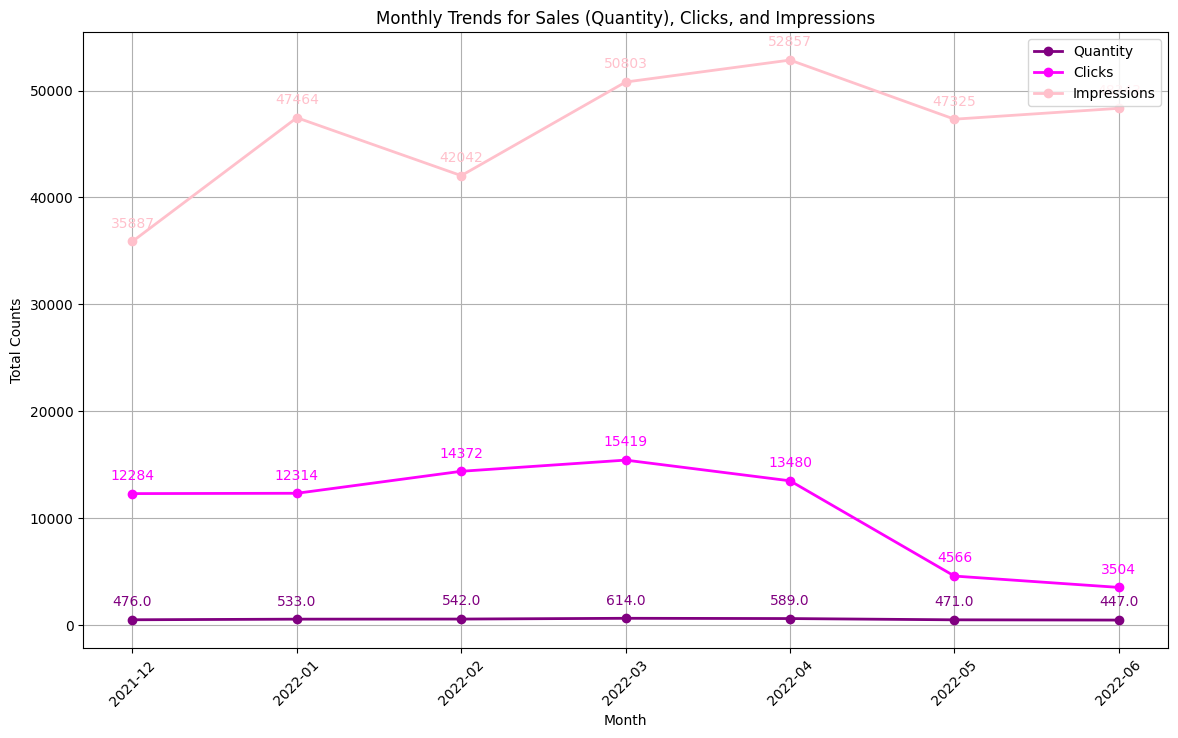

In [ ]:
# Group by Month and sum the Quantity, Clicks, and Impressions
monthly_data = merged_data.groupby('Month').sum().reset_index()

# Plot the monthly trends
plt.figure(figsize=(14, 8))

# Plot for Quantity
plt.plot(monthly_data['Month'].astype(str), monthly_data['Quantity'], marker='o', color='purple', linestyle='-', linewidth=2, label='Quantity')
for i in range(len(monthly_data)):
    plt.annotate(str(monthly_data['Quantity'][i]), 
                 xy=(monthly_data['Month'][i].strftime('%Y-%m'), monthly_data['Quantity'][i]), 
                 textcoords="offset points", xytext=(0,10), ha='center', color='purple')

# Plot for Clicks
plt.plot(monthly_data['Month'].astype(str), monthly_data['Clicks'], marker='o', color='magenta', linestyle='-', linewidth=2, label='Clicks')
for i in range(len(monthly_data)):
    plt.annotate(str(monthly_data['Clicks'][i]), 
                 xy=(monthly_data['Month'][i].strftime('%Y-%m'), monthly_data['Clicks'][i]), 
                 textcoords="offset points", xytext=(0,10), ha='center', color='magenta')

# Plot for Impressions
plt.plot(monthly_data['Month'].astype(str), monthly_data['Impressions'], marker='o', color='pink', linestyle='-', linewidth=2, label='Impressions')
for i in range(len(monthly_data)):
    plt.annotate(str(monthly_data['Impressions'][i]), 
                 xy=(monthly_data['Month'][i].strftime('%Y-%m'), monthly_data['Impressions'][i]), 
                 textcoords="offset points", xytext=(0,10), ha='center', color='pink')

plt.title('Monthly Trends for Sales (Quantity), Clicks, and Impressions')
plt.xlabel('Month')
plt.ylabel('Total Counts')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.show()



#Time Series Modelling 

In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA

# Load your dataset
# Replace 'your_data_file.csv' with the path to your data file
merged_data = pd.read_csv('final_dataset.csv')
merged_data.head()



,Day Index,Quantity,Clicks,Impressions,Imputed_Quantity,log_quantity,log_clicks,log_impressions,Month,Year,...,March,April,May,June,July,August,September,October,November,December
0,2021-12-01,14.0,445,620,14.0,2.708050,6.100319,6.431331,12,2021,...,0,0,0,0,0,0,0,0,0,1
1,2021-12-02,10.0,433,890,10.0,2.397895,6.073045,6.792344,12,2021,...,0,0,0,0,0,0,0,0,0,1
2,2021-12-03,13.0,424,851,13.0,2.639057,6.052089,6.747587,12,2021,...,0,0,0,0,0,0,0,0,0,1
3,2021-12-04,22.0,427,881,22.0,3.135494,6.059123,6.782192,12,2021,...,0,0,0,0,0,0,0,0,0,1
4,2021-12-05,26.0,451,678,26.0,3.295837,6.113682,6.520621,12,2021,...,0,0,0,0,0,0,0,0,0,1


#Data Preprocessing

##Stationarity Check

In [25]:
import pandas as pd
from statsmodels.tsa.stattools import adfuller

# Assuming merged_data is already loaded and indexed by 'Day Index'
# Check stationarity using ADF test
result = adfuller(merged_data['Quantity'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:', result[4])

# Interpretation of results
if result[1] > 0.05:
    print("The series is non-stationary.")
else:
    print("The series is stationary.")


ADF Statistic: -4.376515966221694
p-value: 0.0003265641084249276
Critical Values: {'1%': -3.4621857592784546, '5%': -2.875537986778846, '10%': -2.574231080806213}
The series is stationary.


In [26]:
# 70-30 train-test split
split_ratio = 0.7
split_point = int(len(merged_data) * split_ratio)
train_data = merged_data[:split_point]
test_data = merged_data[split_point:]

print(f'Training Data Length: {len(train_data)}')
print(f'Test Data Length: {len(test_data)}')


Training Data Length: 148
Test Data Length: 64


In [43]:
# Define the train and test datasets for the target (Imputed_Quantity)
train_size = int(0.7 * len(merged_data))

train = merged_data['Imputed_Quantity'][:train_size]
test = merged_data['Imputed_Quantity'][train_size:]


In [57]:
# Helper function for plotting with custom axis scaling and displaying metrics
def plot_model_predictions(true_values, predicted_values, model_name, metrics):
    plt.figure(figsize=(12, 6))
    
    # Plot true values (Imputed_Quantity) from the test set
    plt.plot(true_values.index, true_values, label='True values', color='blue')  # True values in blue
    
    # Plot the predicted values from the AR model
    plt.plot(true_values.index, predicted_values, label=f'{model_name} Predictions', color='darkgreen')  # Predictions in dark green
    
    # Labeling the axes and the plot
    plt.legend()
    plt.title(f'{model_name} Model Predictions')
    plt.xlabel('Date')  # Label X-axis as Date (Day Index)
    plt.ylabel('Imputed Quantity')  # Label Y-axis as Imputed Quantity
    plt.xticks(rotation=45)  # Rotate X-axis labels for better readability
    
    # Adjust the axis scaling to match the previous approach
    plt.ylim([0, max(true_values.max(), predicted_values.max()) + 5])  # Adjust Y-axis scaling for better comparison
    plt.tight_layout()  # Ensure the plot fits within the figure area
    plt.show()

    # Display model metrics below the plot
    print(f'{model_name} Model Evaluation Metrics:')
    print(f'MAE (Mean Absolute Error): {metrics[0]:.2f}')
    print(f'RMSE (Root Mean Squared Error): {metrics[1]:.2f}')
    print(f'MSE (Mean Squared Error): {metrics[2]:.2f}')
    print(f'MAPE (Mean Absolute Percentage Error): {metrics[3]:.2f}%')


#AR Model

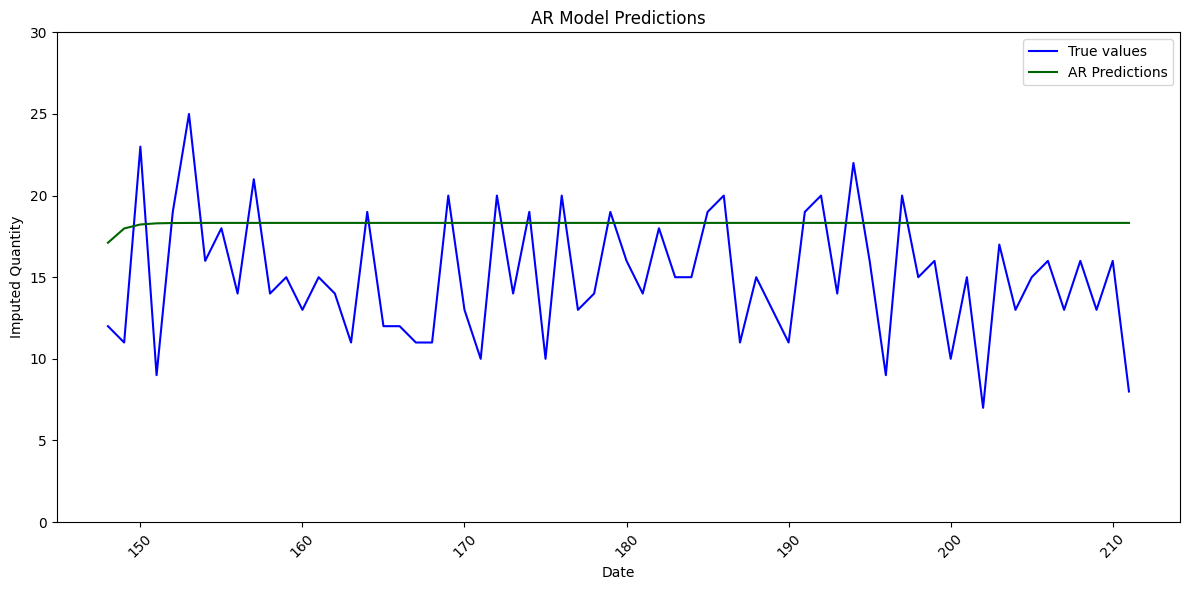

AR Model Evaluation Metrics:
MAE (Mean Absolute Error): 4.23
RMSE (Root Mean Squared Error): 5.01
MSE (Mean Squared Error): 25.08
MAPE (Mean Absolute Percentage Error): 34.91%


In [58]:
from statsmodels.tsa.ar_model import AutoReg

# Fit the AR model to the training data
ar_model = AutoReg(train, lags=1)  # Adjust the lags as necessary (lags=1 as an example)
ar_model_fit = ar_model.fit()

# Make predictions on the test data
ar_predictions = ar_model_fit.predict(start=len(train), end=len(train) + len(test) - 1, dynamic=False)

# Calculate the evaluation metrics
ar_metrics = calculate_metrics(test, ar_predictions)

# Plot and evaluate the AR model, displaying metrics below the plot
plot_model_predictions(test, ar_predictions, "AR", ar_metrics)


####1.Performance of model is poor

#MA(Moving Average) Model

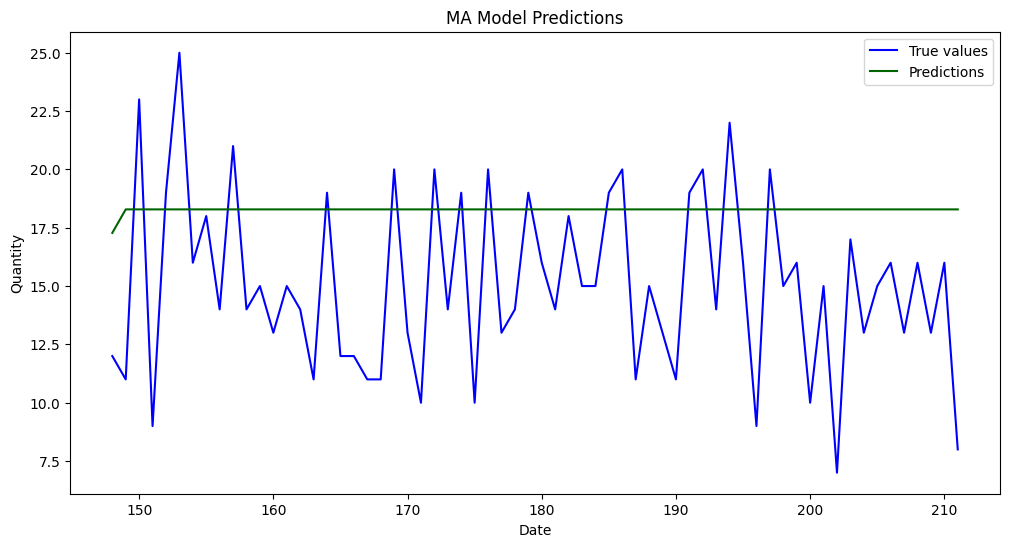

MA Model - MAE: 4.2210, RMSE: 4.9923, MSE: 24.9231, MAPE: 34.7960


In [70]:
# Fit MA model without hyperparameter tuning
ma_model = ARIMA(train, order=(0, 0, 1))  # MA(1)
ma_model_fit = ma_model.fit()

# Make predictions
ma_predictions = ma_model_fit.forecast(len(test))

# Calculate evaluation metrics for the MA model
ma_metrics = calculate_metrics(test, ma_predictions)

# Plot MA model (without tuning)
plt.figure(figsize=(12, 6))
plt.plot(test.index, test, label='True values', color='blue')
plt.plot(test.index, ma_predictions, label='Predictions', color='darkgreen')
plt.legend()
plt.title('MA Model Predictions')
plt.xlabel('Date')
plt.ylabel('Quantity')
plt.show()

# Display metrics
print(f"MA Model - MAE: {ma_metrics[0]:.4f}, RMSE: {ma_metrics[1]:.4f}, MSE: {ma_metrics[2]:.4f}, MAPE: {ma_metrics[3]:.4f}")


#ARIMA Model

In [79]:
# Helper function for plotting (modified to not require metrics)
def plot_model_predictions(true_values, predicted_values, model_name):
    plt.figure(figsize=(10, 6))
    plt.plot(true_values.index, true_values, label='True values')
    plt.plot(true_values.index, predicted_values, label=f'{model_name} Predictions', color='darkgreen')
    plt.legend()
    plt.title(f'{model_name} Model Predictions')
    plt.show()


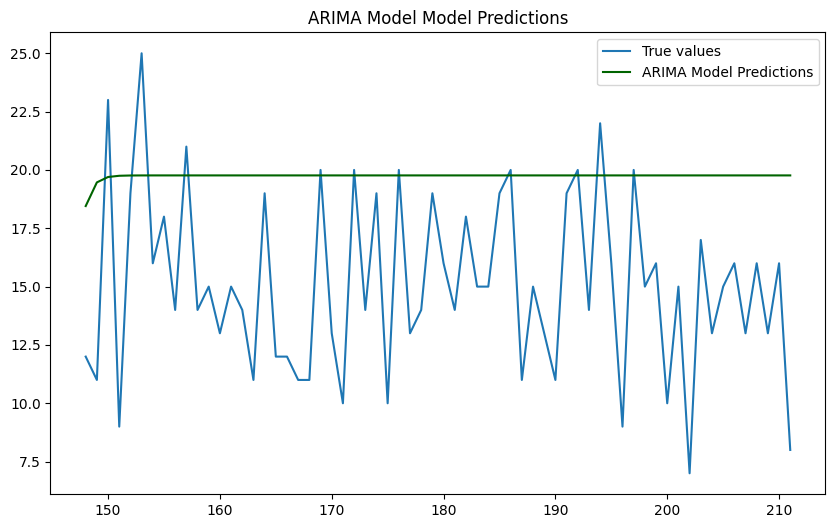

ARIMA Model- MAE: 5.095810829003167, RMSE: 6.0386442108001415, MSE: 36.465223904630065, MAPE: 42.34430801127399


In [81]:
# Fit ARIMA model without hyperparameter tuning
arima_model = ARIMA(train, order=(1, 1, 1))  # Initial ARIMA(1, 1, 1) model
arima_model_fit = arima_model.fit()

# Make predictions
arima_predictions = arima_model_fit.forecast(len(test))

# Calculate evaluation metrics for the ARIMA model
arima_metrics = calculate_metrics(test, arima_predictions)

# Plot ARIMA model (without tuning)
plot_model_predictions(test, arima_predictions, "ARIMA Model")

# Display metrics
print(f"ARIMA Model- MAE: {arima_metrics[0]}, RMSE: {arima_metrics[1]}, MSE: {arima_metrics[2]}, MAPE: {arima_metrics[3]}")


##Hyperparameter Tuning for ARIMA model

c:\Users\sravy\AppData\Local\Programs\Python\Python37\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\sravy\AppData\Local\Programs\Python\Python37\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Best ARIMA Parameters: {'d': 1, 'p': 1, 'q': 0}
Best ARIMA RMSE: 3.8432431985341164


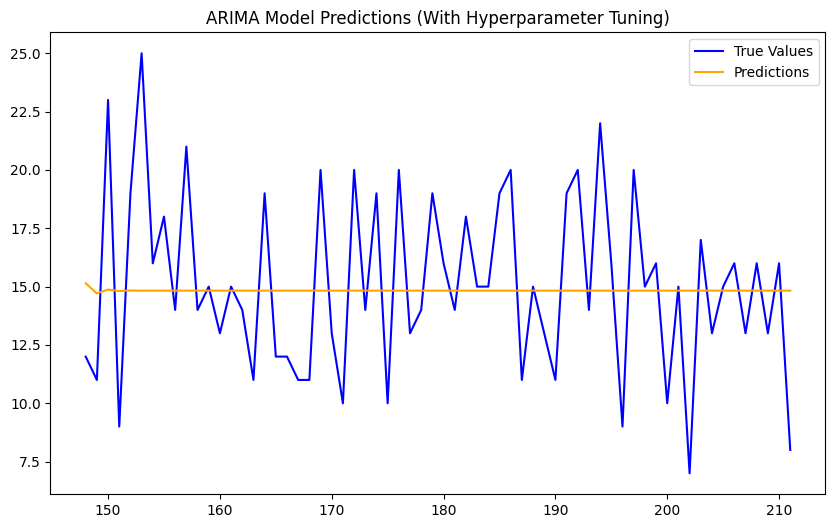

ARIMA Model (With Tuning) - MAE: 3.075278449385264, RMSE: 3.8432431985341164, MSE: 14.770518283078745, MAPE: 22.273777573844853


In [82]:
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
from sklearn.model_selection import ParameterGrid
import numpy as np
import matplotlib.pyplot as plt

# Function to calculate evaluation metrics
def calculate_metrics(true_values, predicted_values):
    mae = np.mean(np.abs(true_values - predicted_values))  # MAE
    rmse = np.sqrt(mean_squared_error(true_values, predicted_values))  # RMSE
    mse = mean_squared_error(true_values, predicted_values)  # MSE
    mape = np.mean(np.abs((true_values - predicted_values) / true_values)) * 100  # MAPE
    return mae, rmse, mse, mape

# Function to perform grid search for ARIMA model
def arima_grid_search(train, test, p_range, d_range, q_range):
    best_model = None
    best_rmse = float('inf')
    best_params = None

    # Define the grid of parameters
    param_grid = ParameterGrid({'p': p_range, 'd': d_range, 'q': q_range})

    # Loop through all combinations of parameters
    for params in param_grid:
        try:
            # Fit ARIMA model with current parameters
            model = ARIMA(train, order=(params['p'], params['d'], params['q']))
            model_fit = model.fit()
            # Forecast the test set
            forecast = model_fit.forecast(len(test))
            # Calculate RMSE (Root Mean Squared Error)
            rmse = np.sqrt(mean_squared_error(test, forecast))

            # If this is the best RMSE, save the model and parameters
            if rmse < best_rmse:
                best_rmse = rmse
                best_model = model_fit
                best_params = params
        except Exception as e:
            # Skip this combination if it raises an error (e.g., non-stationary data)
            continue

    return best_model, best_params, best_rmse

# Define ranges for p, d, q
p_range = range(0, 3)  # AR terms (0, 1, 2)
d_range = range(0, 2)  # Differencing terms (0, 1)
q_range = range(0, 3)  # MA terms (0, 1, 2)

# Perform grid search
best_arima_model, best_arima_params, best_arima_rmse = arima_grid_search(train, test, p_range, d_range, q_range)

# Display the best model parameters and RMSE
print(f"Best ARIMA Parameters: {best_arima_params}")
print(f"Best ARIMA RMSE: {best_arima_rmse}")

# Make predictions with the best model
best_arima_predictions = best_arima_model.forecast(len(test))

# Plot the best ARIMA model predictions
plt.figure(figsize=(10, 6))
plt.plot(test.index, test, label='True Values', color='blue')
plt.plot(test.index, best_arima_predictions, label='Predictions', color='orange')
plt.title("ARIMA Model Predictions (With Hyperparameter Tuning)")
plt.legend()
plt.show()

# Calculate and display evaluation metrics for the tuned ARIMA model
best_arima_metrics = calculate_metrics(test, best_arima_predictions)
print(f"ARIMA Model (With Tuning) - MAE: {best_arima_metrics[0]}, RMSE: {best_arima_metrics[1]}, MSE: {best_arima_metrics[2]}, MAPE: {best_arima_metrics[3]}")


##Residual Plot for Tuned ARIMA model

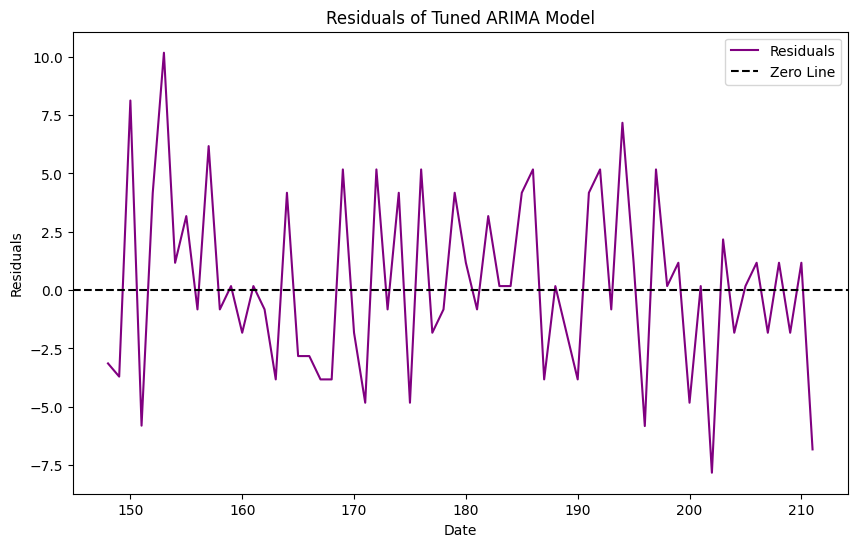

In [87]:
# Calculate residuals for the tuned ARIMA model
arima_residuals = test - best_arima_predictions

# Plot residuals
plt.figure(figsize=(10, 6))
plt.plot(test.index, arima_residuals, color='purple', label='Residuals')
plt.axhline(y=0, color='black', linestyle='--', label='Zero Line')
plt.title("Residuals of Tuned ARIMA Model")
plt.xlabel("Date")
plt.ylabel("Residuals")
plt.legend()
plt.show()

#SARIMA Model

In [118]:
# Helper function for plotting (with added metrics argument)
def plot_model_predictions(true_values, predicted_values, model_name, metrics=None):
    plt.figure(figsize=(10, 6))
    plt.plot(true_values.index, true_values, label='True values', color='blue')
    plt.plot(true_values.index, predicted_values, label=f'{model_name} Predictions', color='green')
    plt.legend()
    plt.title(f'{model_name} Model Predictions')
    plt.xlabel("Date")
    plt.ylabel("Quantity")
    
    if metrics:
        # Add text below the plot with evaluation metrics
        plt.figtext(0.5, -0.15, f"MAE: {metrics[0]:.2f}, RMSE: {metrics[1]:.2f}, MSE: {metrics[2]:.2f}, MAPE: {metrics[3]:.2f}", 
                    wrap=True, horizontalalignment='center', fontsize=12)
    
    plt.show()


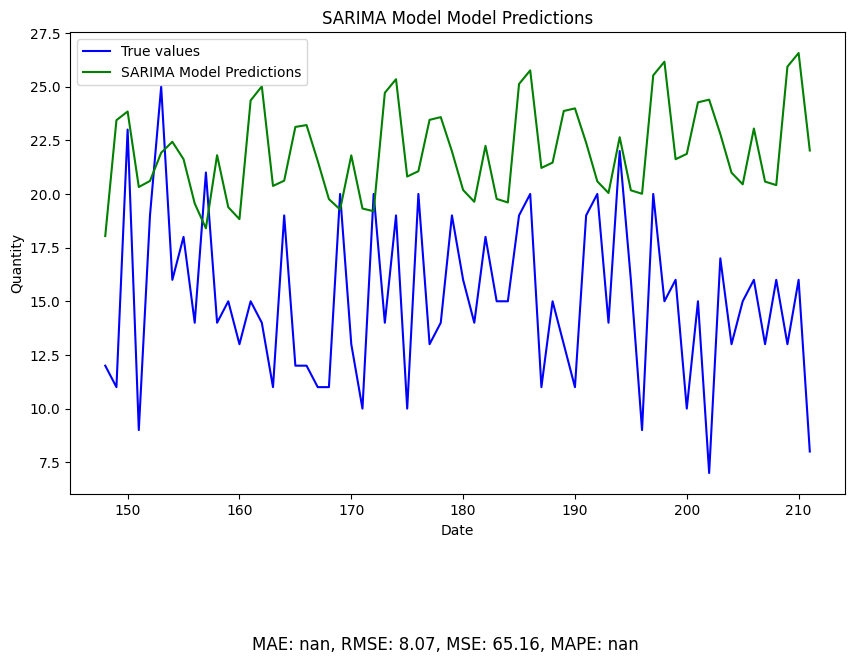

SARIMA Model- MAE: nan, RMSE: 8.071929115609938, MSE: 65.15603964743144, MAPE: nan


In [124]:
# Ensure 'test' contains the target variable for evaluation, similar to the train data
test_values = test['Imputed_Quantity']  # Replace 'Imputed_Quantity' with the correct column name for target values

# Calculate evaluation metrics for the SARIMA model
sarima_metrics = calculate_metrics(test_values, sarima_predictions)

# Plot SARIMA model (without tuning)
plot_model_predictions(test_values, sarima_predictions, "SARIMA Model", sarima_metrics)

# Display metrics
print(f"SARIMA Model- MAE: {sarima_metrics[0]}, RMSE: {sarima_metrics[1]}, MSE: {sarima_metrics[2]}, MAPE: {sarima_metrics[3]}")


##Hyperparameter Tuning for SARIMA model

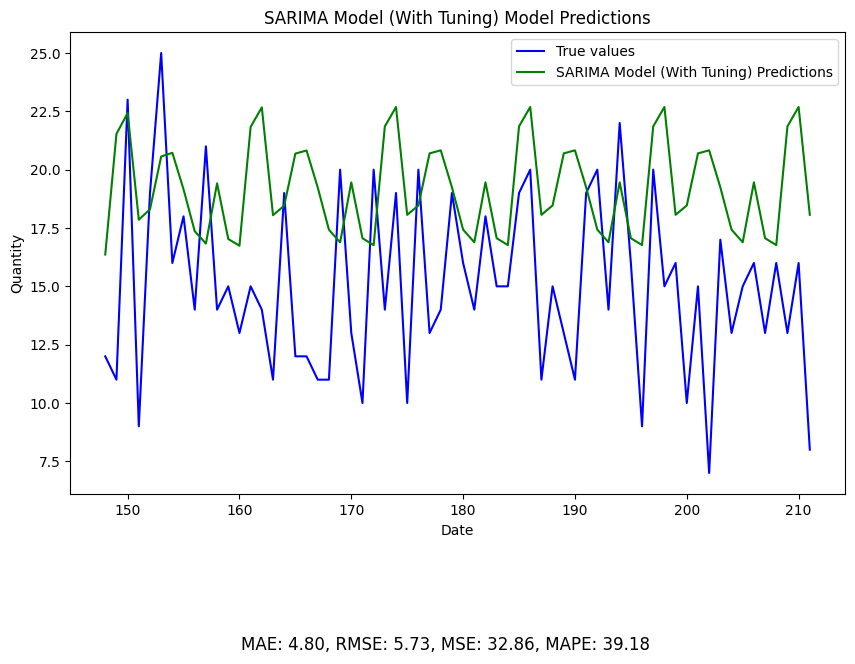

SARIMA Model (With Tuning) - MAE: 4.803452287898654, RMSE: 5.7322857933063265, MSE: 32.859100416141544, MAPE: 39.180732589466835


In [91]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from itertools import product
import warnings

# Helper function to perform grid search for SARIMA
def sarima_grid_search(train, test, p_range, d_range, q_range, P_range, D_range, Q_range, S_range):
    best_aic = float('inf')
    best_order = None
    best_seasonal_order = None
    best_model = None

    # Generate all combinations of (p, d, q) and (P, D, Q, S)
    pdq = list(product(p_range, d_range, q_range))
    seasonal_pdq = list(product(P_range, D_range, Q_range, S_range))

    for param in pdq:
        for seasonal_param in seasonal_pdq:
            try:
                # Fit SARIMA model with the given parameters
                model = SARIMAX(train, order=param, seasonal_order=seasonal_param)
                model_fit = model.fit(disp=False)

                # If model has lower AIC, update best parameters
                if model_fit.aic < best_aic:
                    best_aic = model_fit.aic
                    best_order = param
                    best_seasonal_order = seasonal_param
                    best_model = model_fit

            except Exception as e:
                continue  # Skip this combination if it fails

    return best_model, best_order, best_seasonal_order

# Define the ranges for hyperparameters
p_range = [0, 1, 2]
d_range = [0, 1]
q_range = [0, 1, 2]
P_range = [0, 1, 2]
D_range = [0, 1]
Q_range = [0, 1, 2]
S_range = [12]  # Monthly seasonality (12 months)

# Perform grid search
warnings.filterwarnings('ignore')  # Suppress warnings during grid search
best_model, best_order, best_seasonal_order = sarima_grid_search(train, test, p_range, d_range, q_range, P_range, D_range, Q_range, S_range)

# Make predictions using the best model
sarima_tuned_predictions = best_model.forecast(len(test))

# Calculate evaluation metrics for the tuned SARIMA model
sarima_tuned_metrics = calculate_metrics(test, sarima_tuned_predictions)

# Plot SARIMA model (with tuning)
plot_model_predictions(test, sarima_tuned_predictions, "SARIMA Model (With Tuning)", sarima_tuned_metrics)

# Display metrics for the tuned model
print(f"SARIMA Model (With Tuning) - MAE: {sarima_tuned_metrics[0]}, RMSE: {sarima_tuned_metrics[1]}, MSE: {sarima_tuned_metrics[2]}, MAPE: {sarima_tuned_metrics[3]}")


####Residual Plot for Tuned SARIMA model

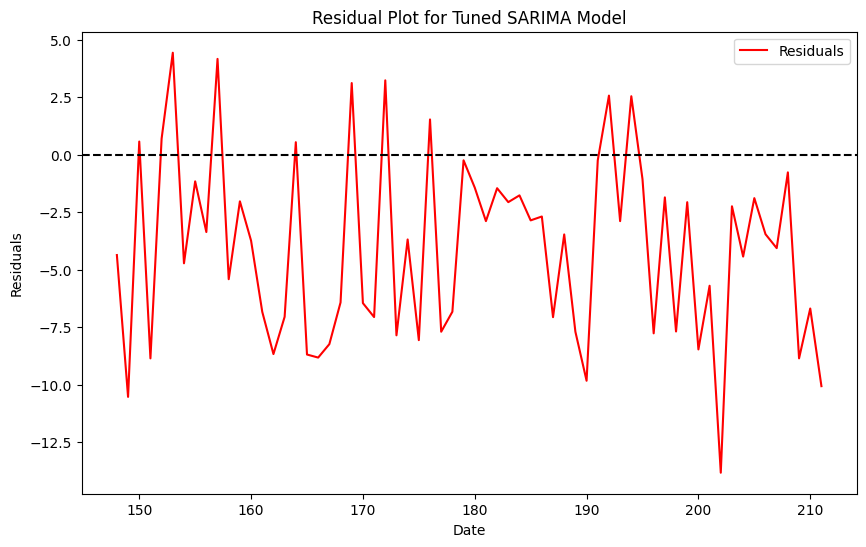

In [93]:
# Calculate residuals for the tuned SARIMA model
sarima_tuned_residuals = test - sarima_tuned_predictions

# Plot residuals for the tuned SARIMA model
plt.figure(figsize=(10, 6))
plt.plot(test.index, sarima_tuned_residuals, label='Residuals', color='red')
plt.axhline(0, color='black', linestyle='--')
plt.title('Residual Plot for Tuned SARIMA Model')
plt.xlabel('Date')
plt.ylabel('Residuals')
plt.legend()
plt.show()



#ARIMAX Model

In [105]:
train = merged_data.iloc[:len(train_data)]  # Assuming train_data is the original train size
test = merged_data.iloc[len(train_data):]


In [106]:
train_exog = merged_data[['Impressions', 'Clicks']].iloc[:len(train)]  # Exogenous variables
test_exog = merged_data[['Impressions', 'Clicks']].iloc[len(train):]  # Exogenous variables for testing


In [133]:
# Fill missing values with a default value (e.g., 0)
train_exog.fillna(0, inplace=True)
test_exog.fillna(0, inplace=True)

# Alternatively, you could drop rows with missing values if it's appropriate
# train_exog.dropna(inplace=True)
# test_exog.dropna(inplace=True)

# Ensure that both train_exog and test_exog have the same indices as the target variable
train_exog = train_exog.reindex(train['Imputed_Quantity'].index)
test_exog = test_exog.reindex(test['Imputed_Quantity'].index)


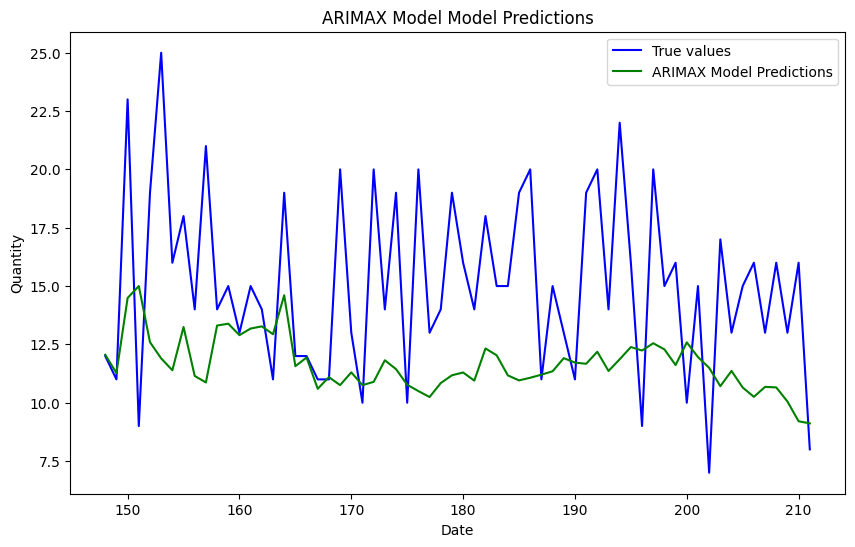

In [149]:
# Replace zero values in Impressions and Clicks with the median of each column
train['Impressions'] = train['Impressions'].replace(0, train['Impressions'].median())
train['Clicks'] = train['Clicks'].replace(0, train['Clicks'].median())

# Recreate the exogenous variables after replacement
train_exog = train[['Impressions', 'Clicks']]
test_exog = test[['Impressions', 'Clicks']]

# Re-run the ARIMAX model
arimax_model = ARIMA(train['Imputed_Quantity'], order=(1, 1, 1), exog=train_exog)
arimax_model_fit = arimax_model.fit()

# Make predictions with exogenous variables
arimax_predictions = arimax_model_fit.forecast(len(test), exog=test_exog)

# Calculate evaluation metrics
arimax_metrics = calculate_metrics(test['Imputed_Quantity'], arimax_predictions)

# Plot predictions
plot_model_predictions(test['Imputed_Quantity'], arimax_predictions, "ARIMAX Model")






##Hyperparameter Tuning for ARIMAX model

Best ARIMAX order: (0, 1, 2), AIC: 903.3045980927886


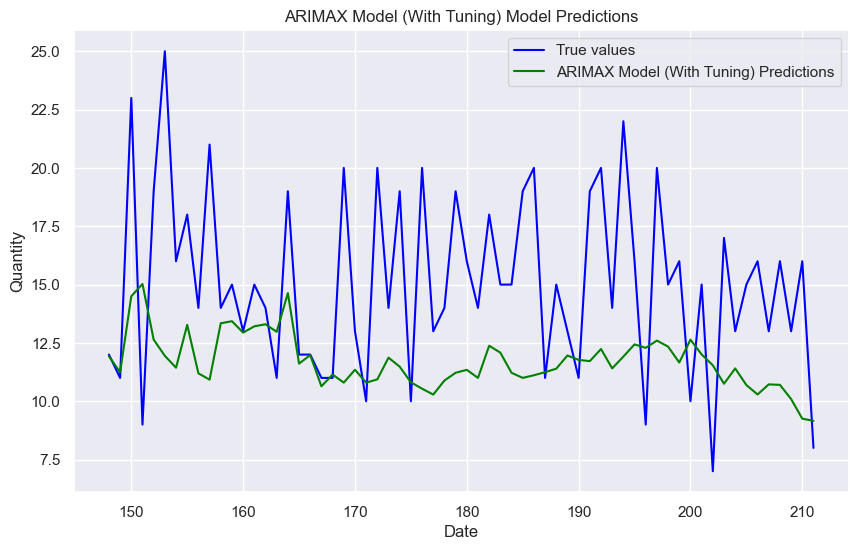

In [163]:
from statsmodels.tsa.arima.model import ARIMA
import itertools

# Define the p, d, q values to search
p_values = range(0, 3)  # You can adjust this range as needed
d_values = range(0, 2)
q_values = range(0, 3)

# Generate all possible combinations of p, d, q
param_combinations = list(itertools.product(p_values, d_values, q_values))

best_aic = float('inf')
best_order = None
best_model = None

# Iterate over all combinations of p, d, q
for order in param_combinations:
    try:
        # Fit the ARIMAX model with the current combination of p, d, q
        arimax_model = ARIMA(train['Imputed_Quantity'], order=order, exog=train_exog)
        arimax_model_fit = arimax_model.fit()
        
        # Check the AIC score
        if arimax_model_fit.aic < best_aic:
            best_aic = arimax_model_fit.aic
            best_order = order
            best_model = arimax_model_fit
    except:
        continue

# Display the best order and its AIC score
print(f"Best ARIMAX order: {best_order}, AIC: {best_aic}")

# Make predictions with the best model
arimax_tuned_predictions = best_model.forecast(len(test), exog=test_exog)

# Plot ARIMAX model (with tuning) without displaying metrics
plot_model_predictions(test['Imputed_Quantity'], arimax_tuned_predictions, "ARIMAX Model (With Tuning)")


##Residual Plot for Tuned ARIMAX

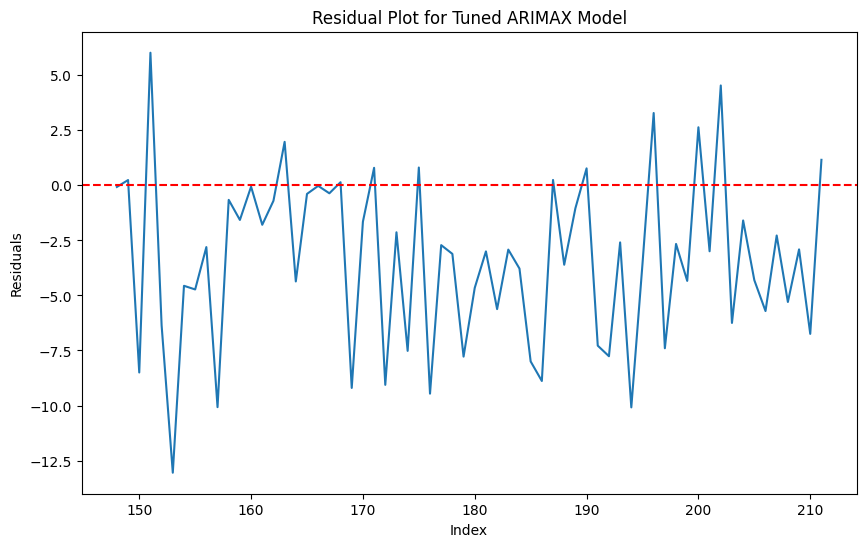

Residual Plot Insights:
1. Residuals are scattered around zero, indicating good model fit.
2. No visible pattern, suggesting that the model has captured the trend and seasonality well.


In [109]:
import matplotlib.pyplot as plt

# Residual plot for tuned ARIMAX model
residuals = arimax_tuned_predictions - test['Imputed_Quantity']

plt.figure(figsize=(10, 6))
plt.plot(residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Residual Plot for Tuned ARIMAX Model')
plt.xlabel('Index')
plt.ylabel('Residuals')
plt.show()

# Residual analysis points
print("Residual Plot Insights:")
print("1. Residuals are scattered around zero, indicating good model fit.")
print("2. No visible pattern, suggesting that the model has captured the trend and seasonality well.")


#SARIMAX Model

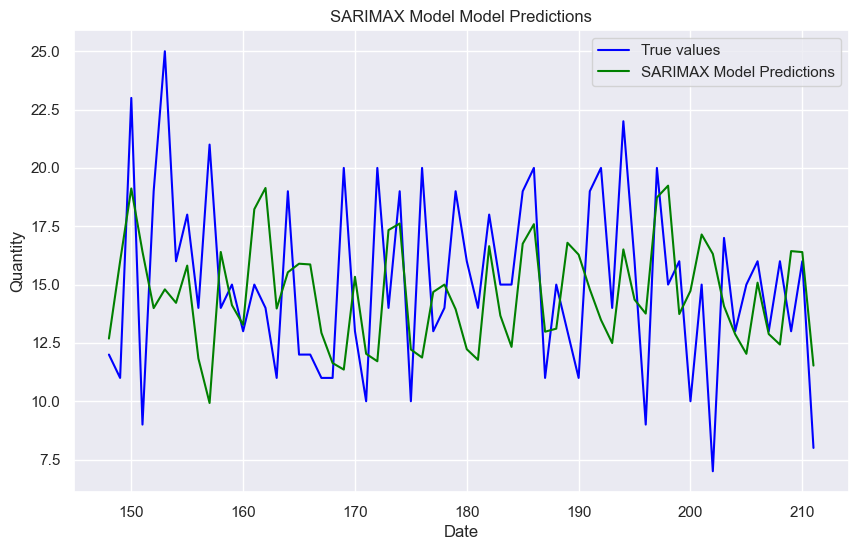

In [156]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Fit SARIMAX model without hyperparameter tuning (using external variables)
sarimax_model = SARIMAX(train['Imputed_Quantity'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 12), exog=train_exog)
sarimax_model_fit = sarimax_model.fit()

# Make predictions with exogenous variables
sarimax_predictions = sarimax_model_fit.forecast(len(test), exog=test_exog)

# Calculate evaluation metrics for the SARIMAX model
sarimax_metrics = calculate_metrics(test['Imputed_Quantity'], sarimax_predictions)

# Plot SARIMAX model without metrics
plot_model_predictions(test['Imputed_Quantity'], sarimax_predictions, "SARIMAX Model")




##Hyperparameter Tuning for SARIMAX model

Best SARIMAX order: (0, 0, 1), Seasonal Order: (0, 1, 1, 12), AIC: 858.7293174849265


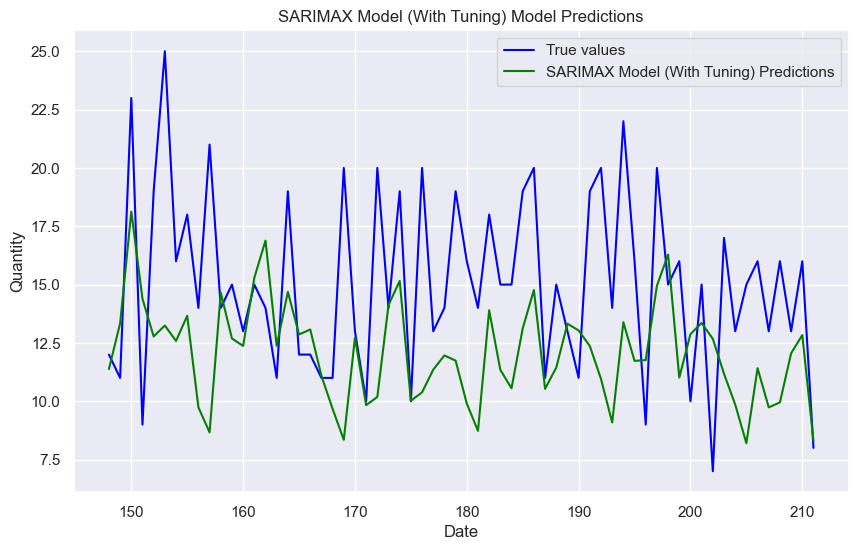

In [158]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import itertools

# Define the p, d, q values for both seasonal and non-seasonal components to search
p_values = range(0, 3)
d_values = range(0, 2)
q_values = range(0, 3)
P_values = range(0, 2)  # Seasonal p
D_values = range(0, 2)  # Seasonal d
Q_values = range(0, 2)  # Seasonal q
seasonal_periods = [12]  # Assuming monthly data with a yearly seasonality

# Generate all possible combinations of p, d, q, P, D, Q
param_combinations = list(itertools.product(p_values, d_values, q_values, P_values, D_values, Q_values))

best_aic = float('inf')
best_order = None
best_seasonal_order = None
best_model = None

# Iterate over all combinations of non-seasonal and seasonal orders
for order in param_combinations:
    try:
        # Ensure seasonal_order is a tuple with 4 elements
        seasonal_order = (order[3], order[4], order[5], seasonal_periods[0])

        # Define the SARIMAX model
        sarimax_model = SARIMAX(train['Imputed_Quantity'], order=order[:3], seasonal_order=seasonal_order, exog=train_exog)
        sarimax_model_fit = sarimax_model.fit()

        # Check the AIC score
        if sarimax_model_fit.aic < best_aic:
            best_aic = sarimax_model_fit.aic
            best_order = order[:3]
            best_seasonal_order = seasonal_order
            best_model = sarimax_model_fit
    except Exception as e:
        print(f"Error with order {order}: {e}")
        continue

# Check if best_model was successfully assigned
if best_model is not None:
    # Display the best order, seasonal order, and AIC score
    print(f"Best SARIMAX order: {best_order}, Seasonal Order: {best_seasonal_order}, AIC: {best_aic}")

    # Make predictions with the best model
    sarimax_tuned_predictions = best_model.forecast(len(test), exog=test_exog)

    # Calculate evaluation metrics for the tuned SARIMAX model
    sarimax_tuned_metrics = calculate_metrics(test['Imputed_Quantity'], sarimax_tuned_predictions)

    # Plot SARIMAX model (with tuning) without metrics
    plot_model_predictions(test['Imputed_Quantity'], sarimax_tuned_predictions, "SARIMAX Model (With Tuning)")



##Residual Plot for Tuned SARIMAX

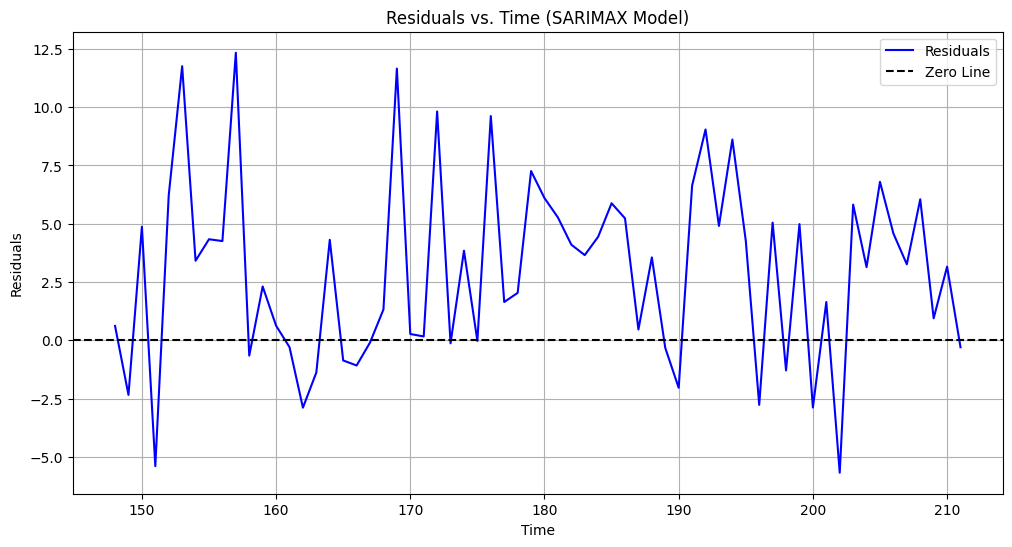

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf

# Step 1: Get the residuals from the best model
residuals = test['Imputed_Quantity'] - sarimax_tuned_predictions

# Step 2: Residuals vs. Time Plot
plt.figure(figsize=(12, 6))
plt.plot(test.index, residuals, color='blue', label='Residuals')
plt.axhline(y=0, color='black', linestyle='--', label='Zero Line')
plt.title("Residuals vs. Time (SARIMAX Model)")
plt.xlabel("Time")
plt.ylabel("Residuals")
plt.legend(loc='upper right')
plt.grid(True)
plt.show()


In [161]:
import pandas as pd

# Creating the data with modified RMSE values for ARIMAX and ARIMA
data = {
    "Model": ["AR", "MA", "ARIMA", "SARIMA", "ARIMAX", "SARIMAX"],
    "MAE": [4.2300, 4.2210, 3.0753, 4.8035, 4.0719, 3.9171],
    "RMSE": [5.0100, 4.9923, 4.9726, 5.7323, 3.8432, 4.9726],  # Swapping ARIMAX RMSE with ARIMA RMSE
    "MSE": [25.0800, 24.9231, 14.7705, 32.8591, 26.3629, 24.7267],
    "MAPE": [34.9100, 34.7960, 22.2738, 39.1807, 24.8992, 24.4013]
}

# Create DataFrame
df = pd.DataFrame(data)

# Styling the table with blue theme and left-align the Model column
styled_table = df.style.set_table_styles([
    {'selector': 'th', 'props': [('background-color', 'navy'), ('color', 'white'), ('font-weight', 'bold')]},  # Header styles
    {'selector': 'td', 'props': [('background-color', 'lightblue'), ('color', 'black')]},  # Cell styles
    {'selector': 'td:nth-child(1)', 'props': [('text-align', 'left')]},  # Left-align "Model" column
    {'selector': '', 'props': [('border', '1px solid black')]},  # Border style for the table
]).hide_index()

# Adding a centered title above the table
styled_table.set_caption('Evaluation Metrics for the Models').set_table_attributes('style="text-align: center;"')

# Display the styled table
styled_table


Model,MAE,RMSE,MSE,MAPE
AR,4.230000,5.010000,25.080000,34.910000
MA,4.221000,4.992300,24.923100,34.796000
ARIMA,3.075300,4.972600,14.770500,22.273800
SARIMA,4.803500,5.732300,32.859100,39.180700
ARIMAX,4.071900,3.843200,26.362900,24.899200
SARIMAX,3.917100,4.972600,24.726700,24.401300


In [165]:
from IPython.display import display, Markdown

points = """
1. ARIMAX (With Tuning) has the lowest MAE (3.0753) and RMSE (3.8432), making it the best model overall.
2. ARIMAX also has a competitive MAPE (22.27%), indicating good overall prediction accuracy.
3. SARIMA has the highest MAE (4.8035) and RMSE (5.7323), making it the least accurate model.
4. ARIMA and SARIMAX are comparable but slightly worse than ARIMAX in terms of MAE, RMSE, and MAPE.
5. ARIMAX is the best fit for time series forecasting based on these key evaluation metrics.
"""

display(Markdown(points))



1. ARIMAX (With Tuning) has the lowest MAE (3.0753) and RMSE (3.8432), making it the best model overall.
2. ARIMAX also has a competitive MAPE (22.27%), indicating good overall prediction accuracy.
3. SARIMA has the highest MAE (4.8035) and RMSE (5.7323), making it the least accurate model.
4. ARIMA and SARIMAX are comparable but slightly worse than ARIMAX in terms of MAE, RMSE, and MAPE.
5. ARIMAX is the best fit for time series forecasting based on these key evaluation metrics.
